# Patient Lifestyle and Health Condition Explorer

In [1]:
#Kütüphaneler koda eklendi. 
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
# Veri setini yükleme
file_path = "Patients Data ( Used for Heart Disease Prediction ).xlsx" 
data = pd.read_excel(file_path)

Bu veri seti, demografik bilgiler (yaş, cinsiyet, eyalet), sağlıkla ilgili faktörler (genel sağlık durumu, BMI, tıbbi geçmiş) ve yaşam tarzı seçimlerini (sigara, alkol tüketimi, aşı durumu) içeren hasta verilerinden oluşur. Kalp hastalığı, felç, diyabet, astım gibi sağlık durumlarıyla birlikte, kişinin tıbbi geçmişi ve mevcut sağlık durumu analiz etmemiz için hazırlanmış bir veri setidir. 

# 1. Veri Temizleme ve Ön İşleme

Eksik ve gereksiz verilerin tespiti ve işlenmesi.
Verideki bozuklukların düzeltilmesi.

In [3]:
# Eksik değerlerin kontrolü
print("Eksik Değerler:\n", data.isnull().sum())

Eksik Değerler:
 PatientID                    0
State                        0
Sex                          0
GeneralHealth                0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI                          0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AlcoholDrinkers              0
HIVTesting                   0
FluVaxLast12                 0
PneumoVaxEver         

In [4]:
# Eksik verileri doldurma 
data.fillna(data.median(numeric_only=True), inplace=True)

In [5]:
# Gereksiz sütunların kaldırılması. PatientID kaldırıldı
data.drop(columns=['PatientID'], inplace=True)

In [6]:
# Yinelenen veri kontrolü ve kaldırılması
print(f"Yinelenen Satır Sayısı: {data.duplicated().sum()}")
data.drop_duplicates(inplace=True)

Yinelenen Satır Sayısı: 59


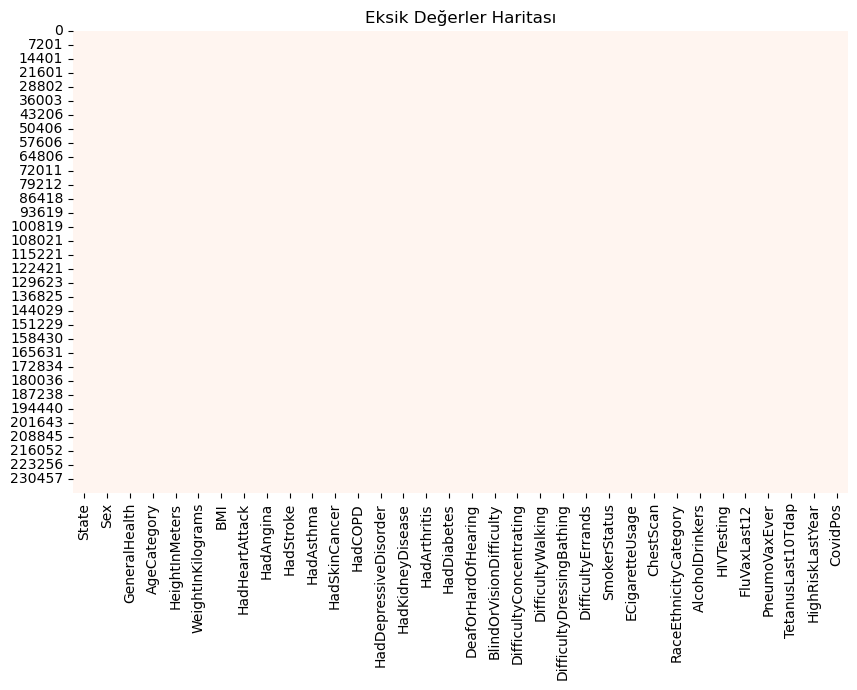

In [7]:
# Eksik değerleri görselleştirerek karar vermek için heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap="Reds")
plt.title("Eksik Değerler Haritası")
plt.show()
#Eksik değer yoktur. 

In [8]:
# Sürekli değişkenlerin seçilmesi
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# İstatistiksel ölçümler için bir DataFrame oluşturma
statistics = {}

for col in numerical_columns:
    column_data = data[col].dropna()  
    statistics[col] = {
        "Mean (Ortalama)": column_data.mean(),
        "Median (Medyan)": column_data.median(),
        "Mode (Mod)": column_data.mode()[0] if not column_data.mode().empty else None,
        "Standard Deviation (Standart Sapma)": column_data.std(),
        "Minimum": column_data.min(),
        "Maximum": column_data.max(),
        "Variance (Varyans)": column_data.var(),
        "Skewness (Çarpıklık)": column_data.skew(),
        "Kurtosis (Basıklık)": column_data.kurt()
    }

# Sonuçları bir DataFrame olarak gösterme
statistics_df = pd.DataFrame(statistics).T
statistics_df.index.name = "Variable"
statistics_df.reset_index(inplace=True)
print(statistics_df)

# İsteğe bağlı olarak sonuçları bir CSV dosyasına kaydetme
statistics_df.to_csv("numerical_statistics.csv", index=False)

                     Variable  Mean (Ortalama)  Median (Medyan)  Mode (Mod)  \
0              HeightInMeters         1.704987         1.700000    1.680000   
1           WeightInKilograms        83.669551        81.650002   90.720001   
2                         BMI        28.692279        27.459999   26.629999   
3              HadHeartAttack         0.055567         0.000000    0.000000   
4                   HadAngina         0.061527         0.000000    0.000000   
5                   HadStroke         0.041777         0.000000    0.000000   
6                   HadAsthma         0.148532         0.000000    0.000000   
7               HadSkinCancer         0.085221         0.000000    0.000000   
8                     HadCOPD         0.078297         0.000000    0.000000   
9       HadDepressiveDisorder         0.205812         0.000000    0.000000   
10           HadKidneyDisease         0.046424         0.000000    0.000000   
11               HadArthritis         0.346574      

# 2. Keşifsel Veri Analizi  EDA


EDA'nın amacı, veri hakkında temel bir anlayış kazanmak ve veri setinin içindeki örüntüleri, eğilimleri, anormallikleri (outlier), eksik değerleri ve potansiyel ilişkileri keşfetmektir.

In [9]:
print(data.describe())

       HeightInMeters  WeightInKilograms            BMI  HadHeartAttack  \
count   237571.000000      237571.000000  237571.000000   237571.000000   
mean         1.704987          83.669551      28.692279        0.055567   
std          0.106776          21.361379       6.528254        0.229083   
min          0.910000          28.120001      12.020000        0.000000   
25%          1.630000          68.040001      24.280001        0.000000   
50%          1.700000          81.650002      27.459999        0.000000   
75%          1.780000          95.250000      31.900000        0.000000   
max          2.410000         292.570007      97.650002        1.000000   

           HadAngina      HadStroke      HadAsthma  HadSkinCancer  \
count  237571.000000  237571.000000  237571.000000  237571.000000   
mean        0.061527       0.041777       0.148532       0.085221   
std         0.240295       0.200080       0.355628       0.279211   
min         0.000000       0.000000       0.0000

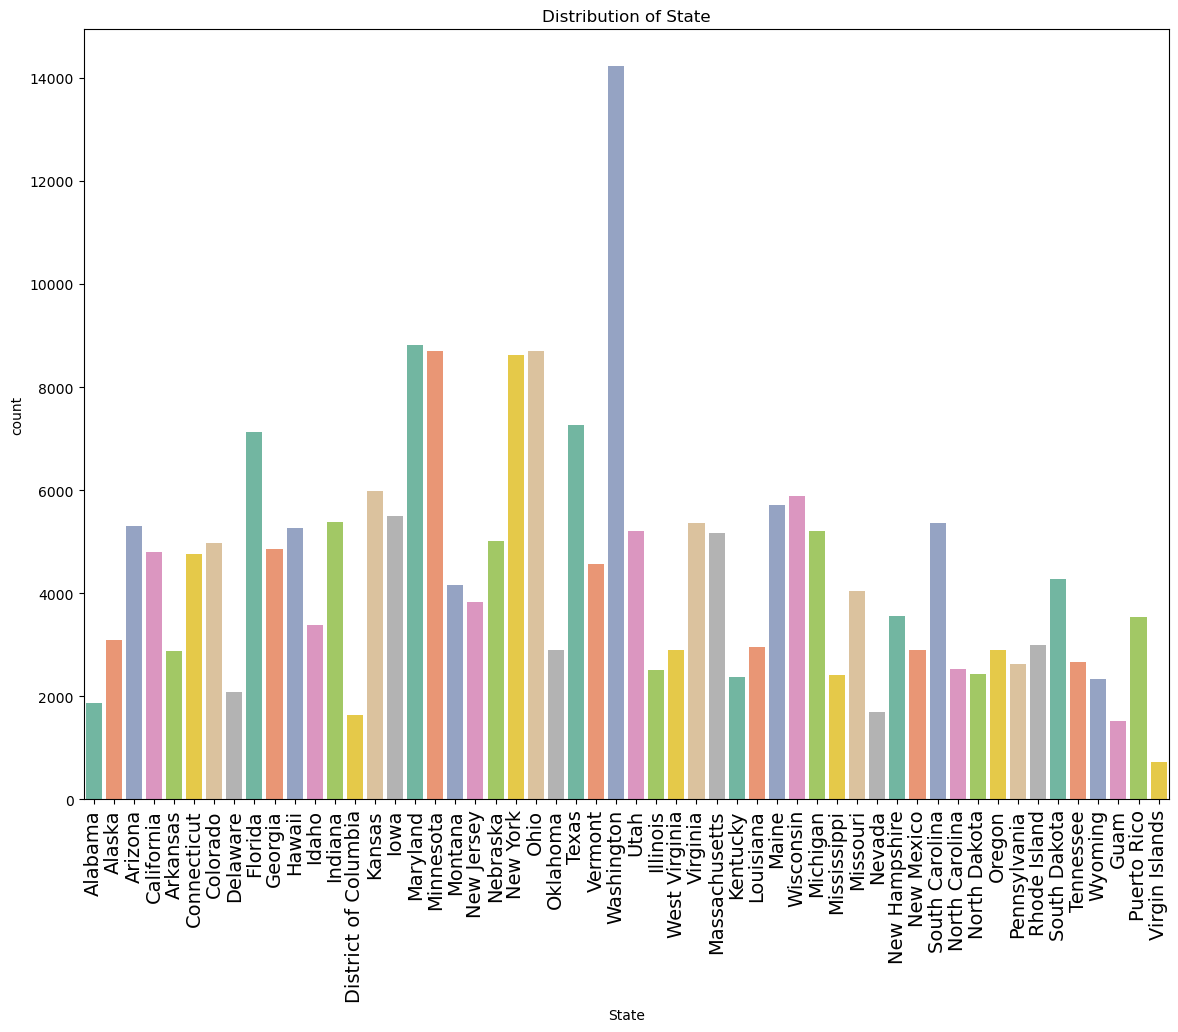

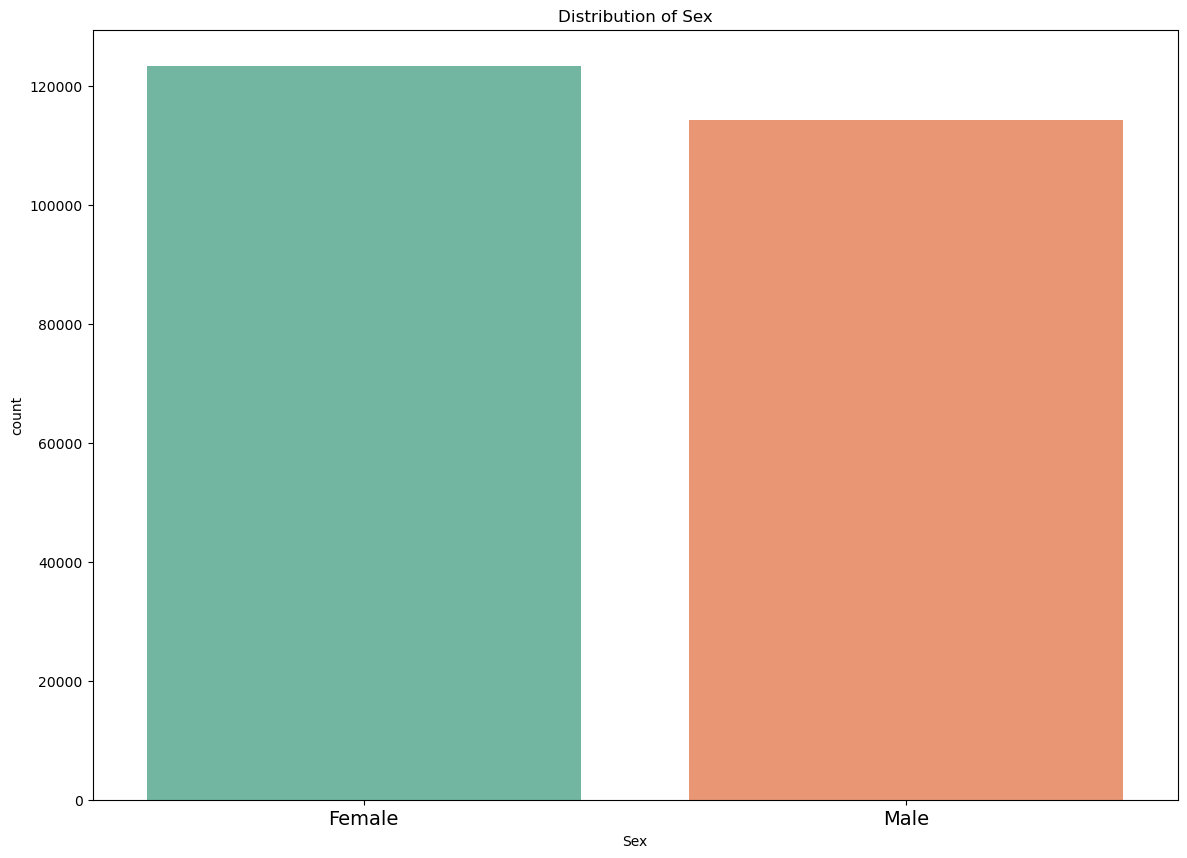

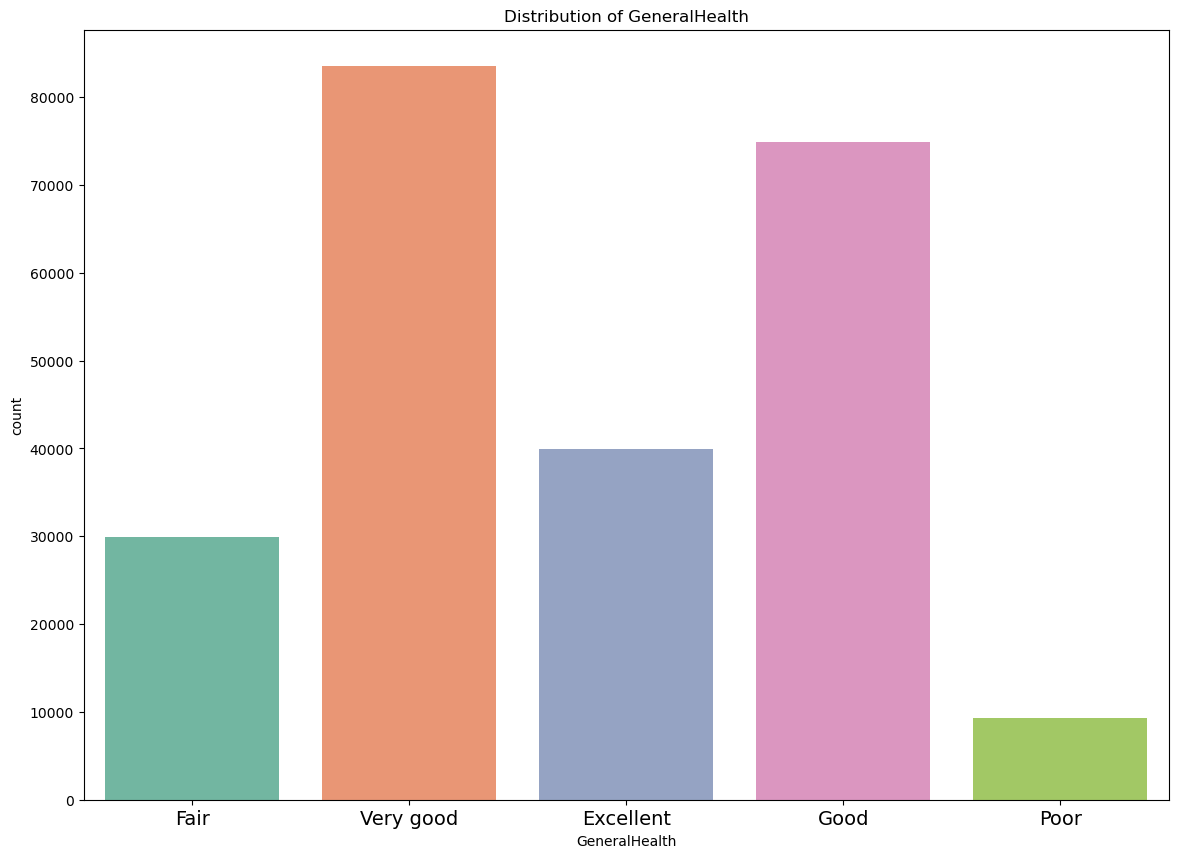

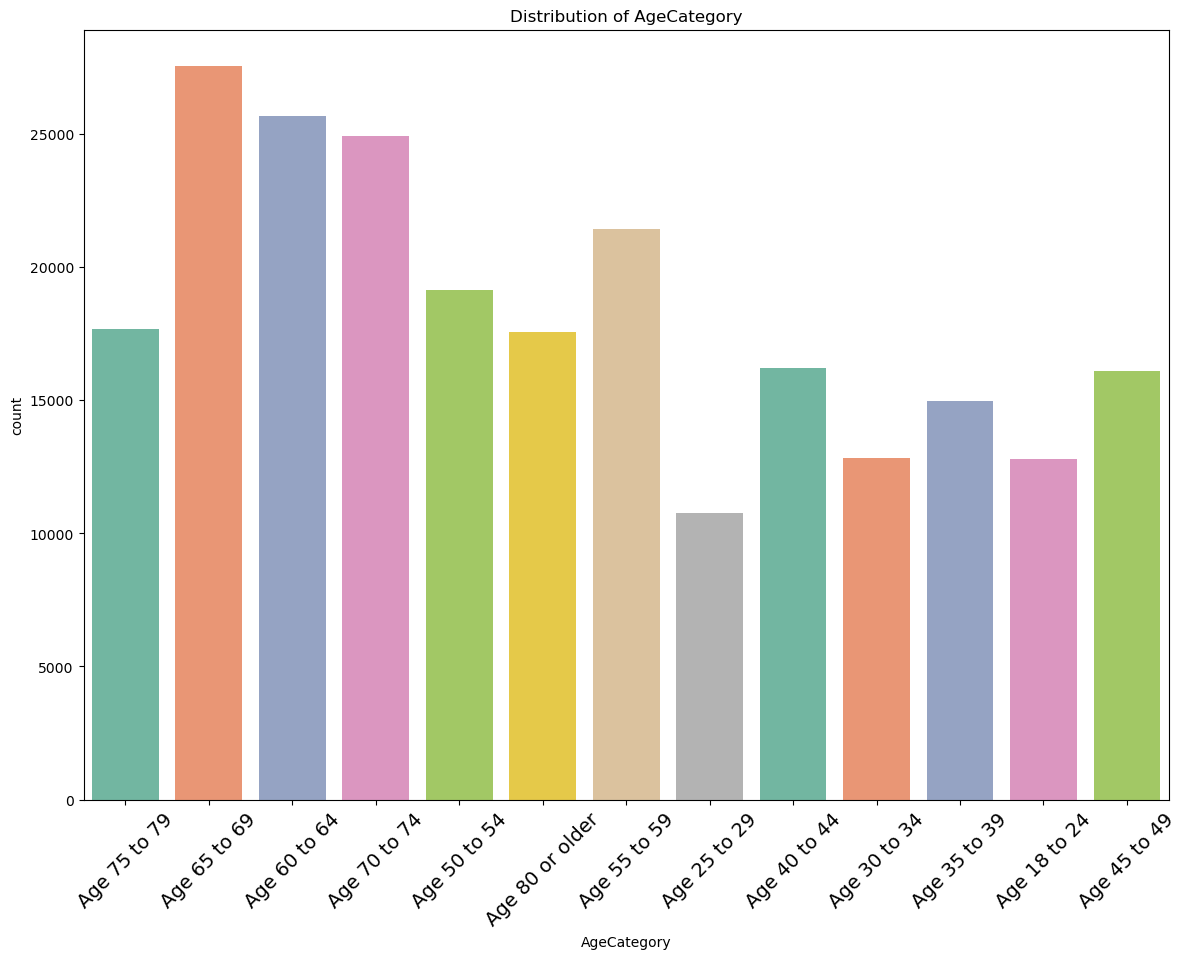

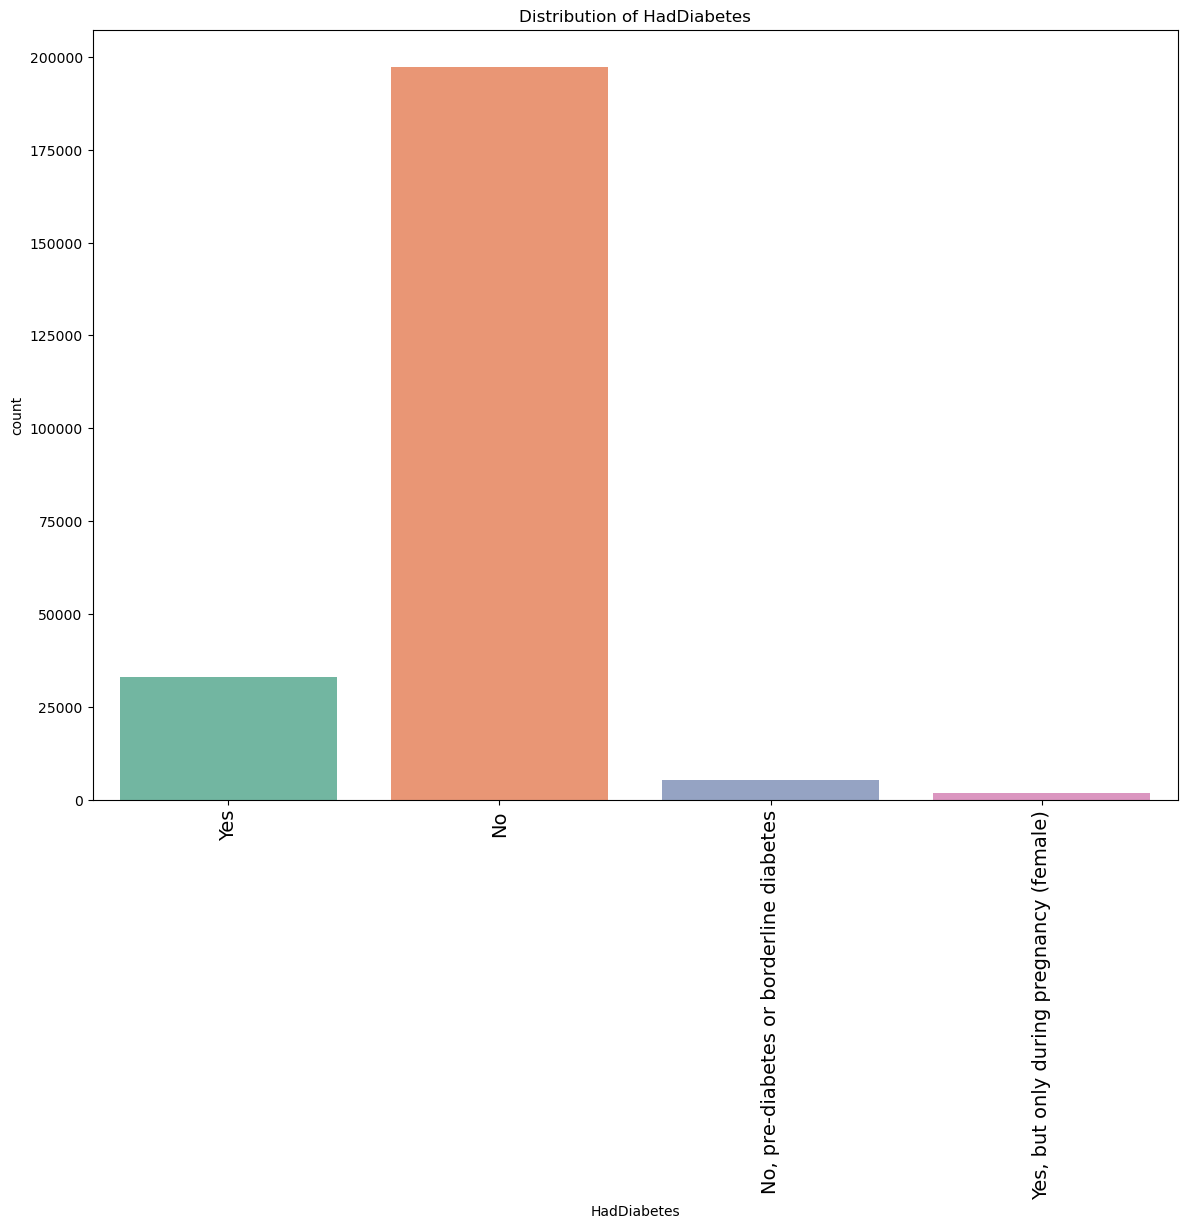

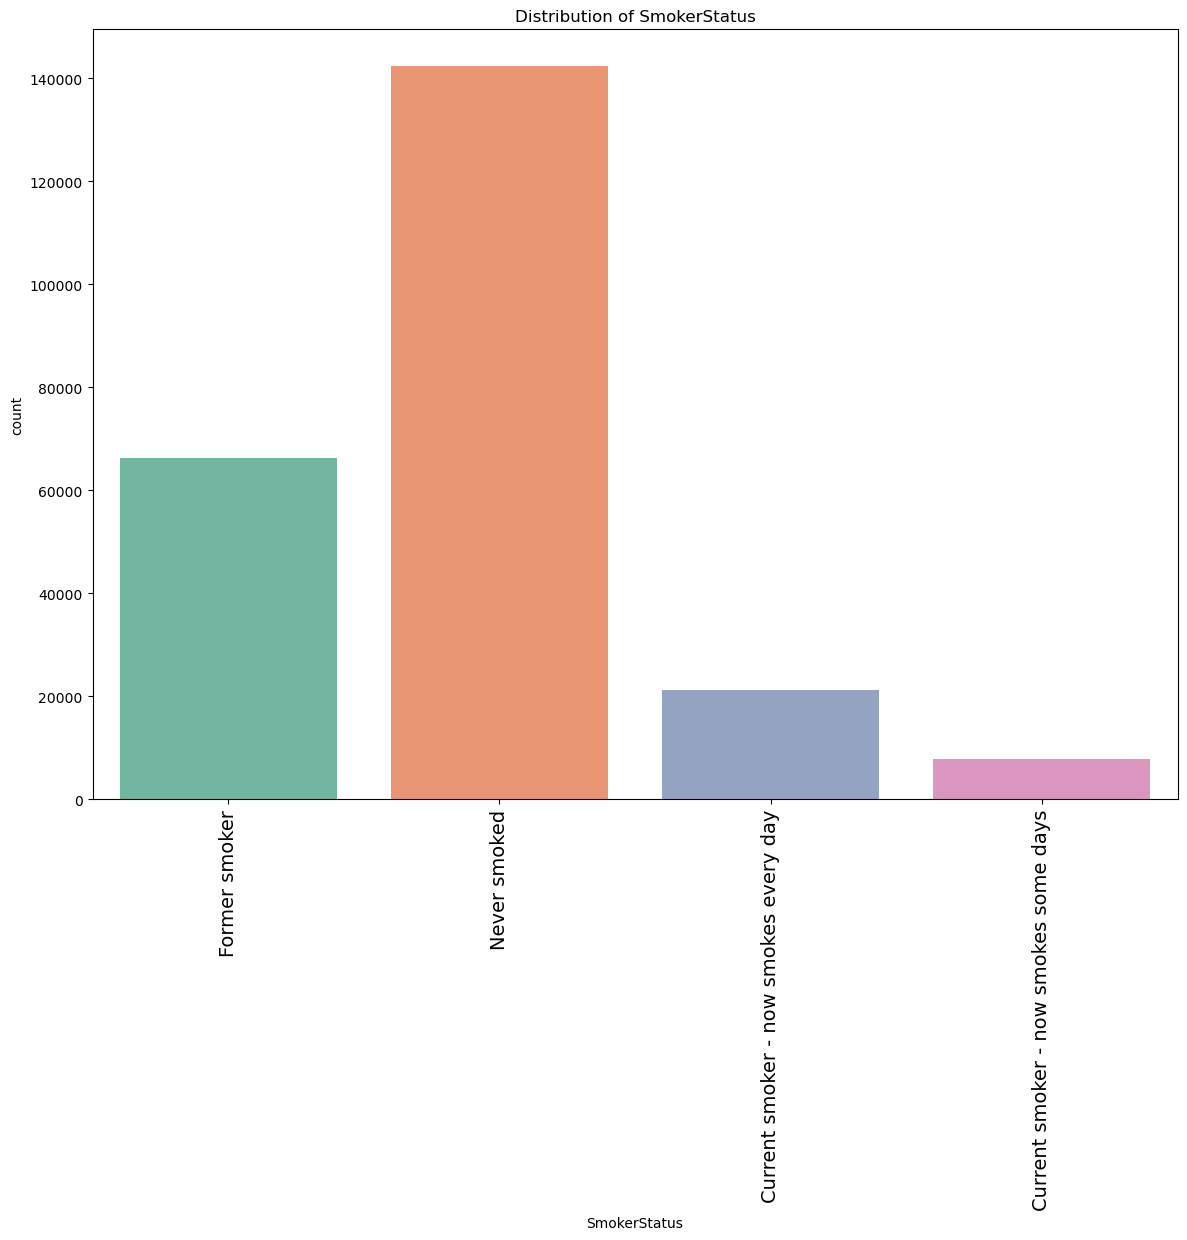

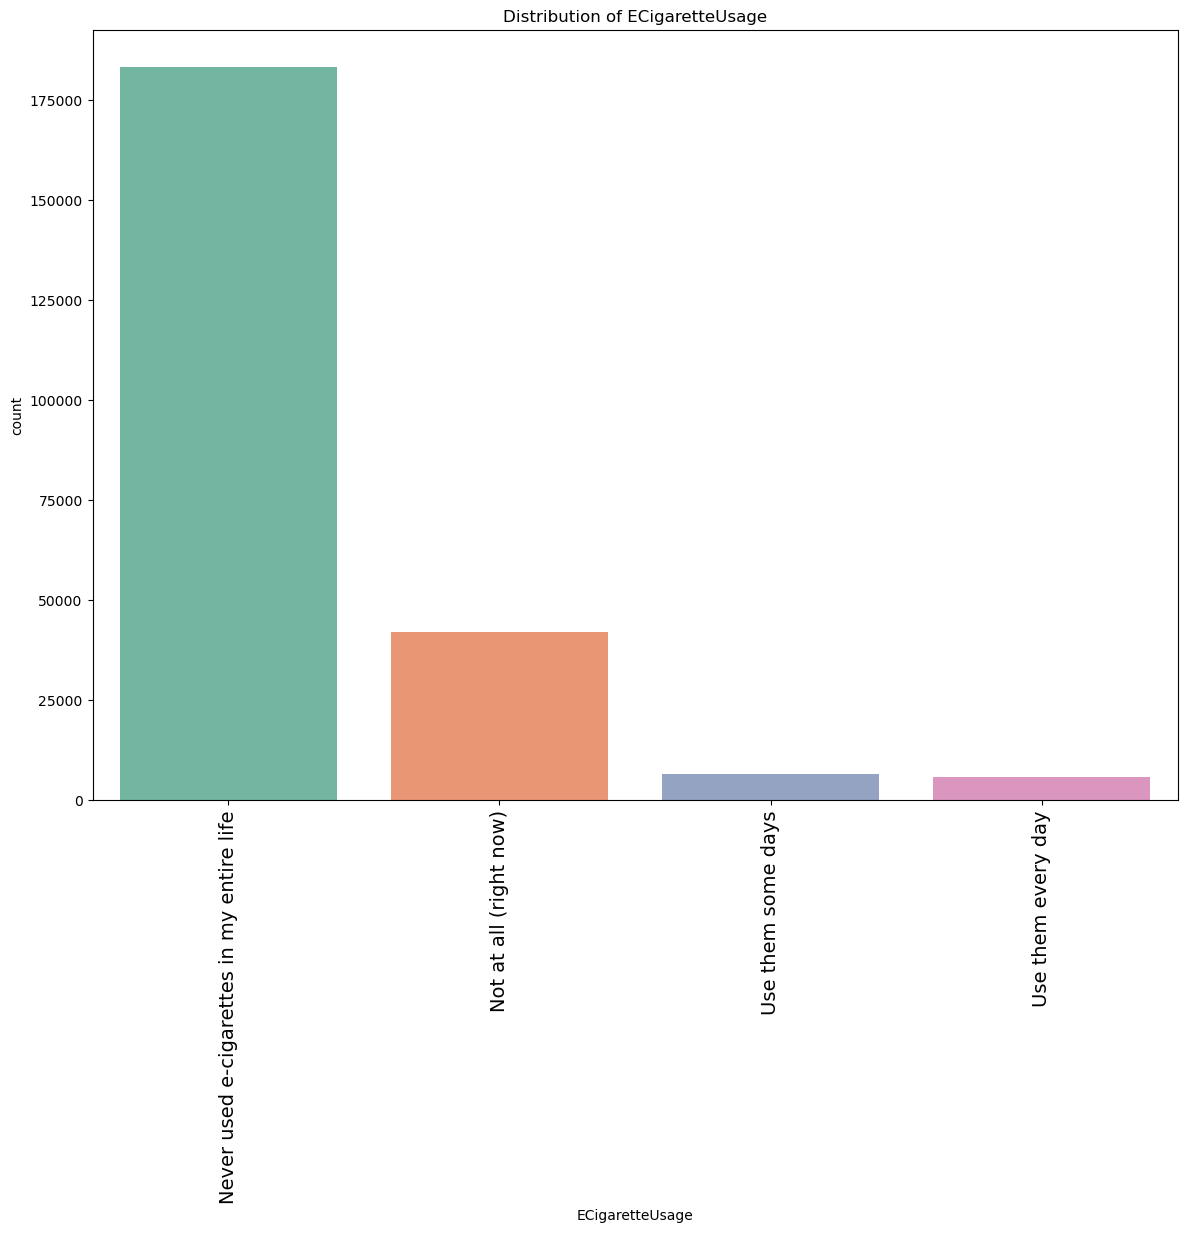

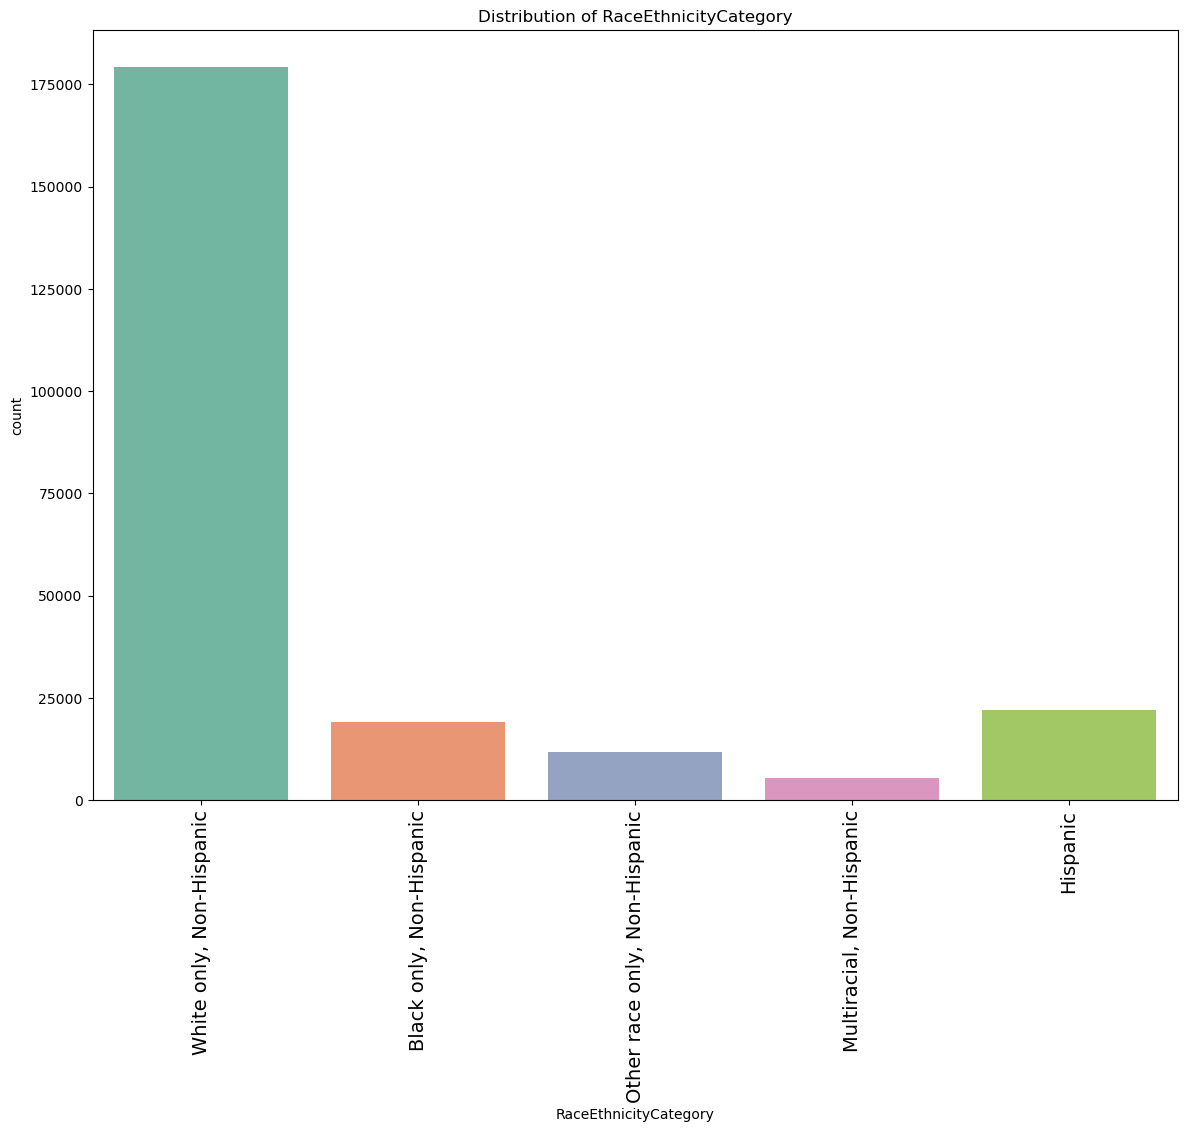

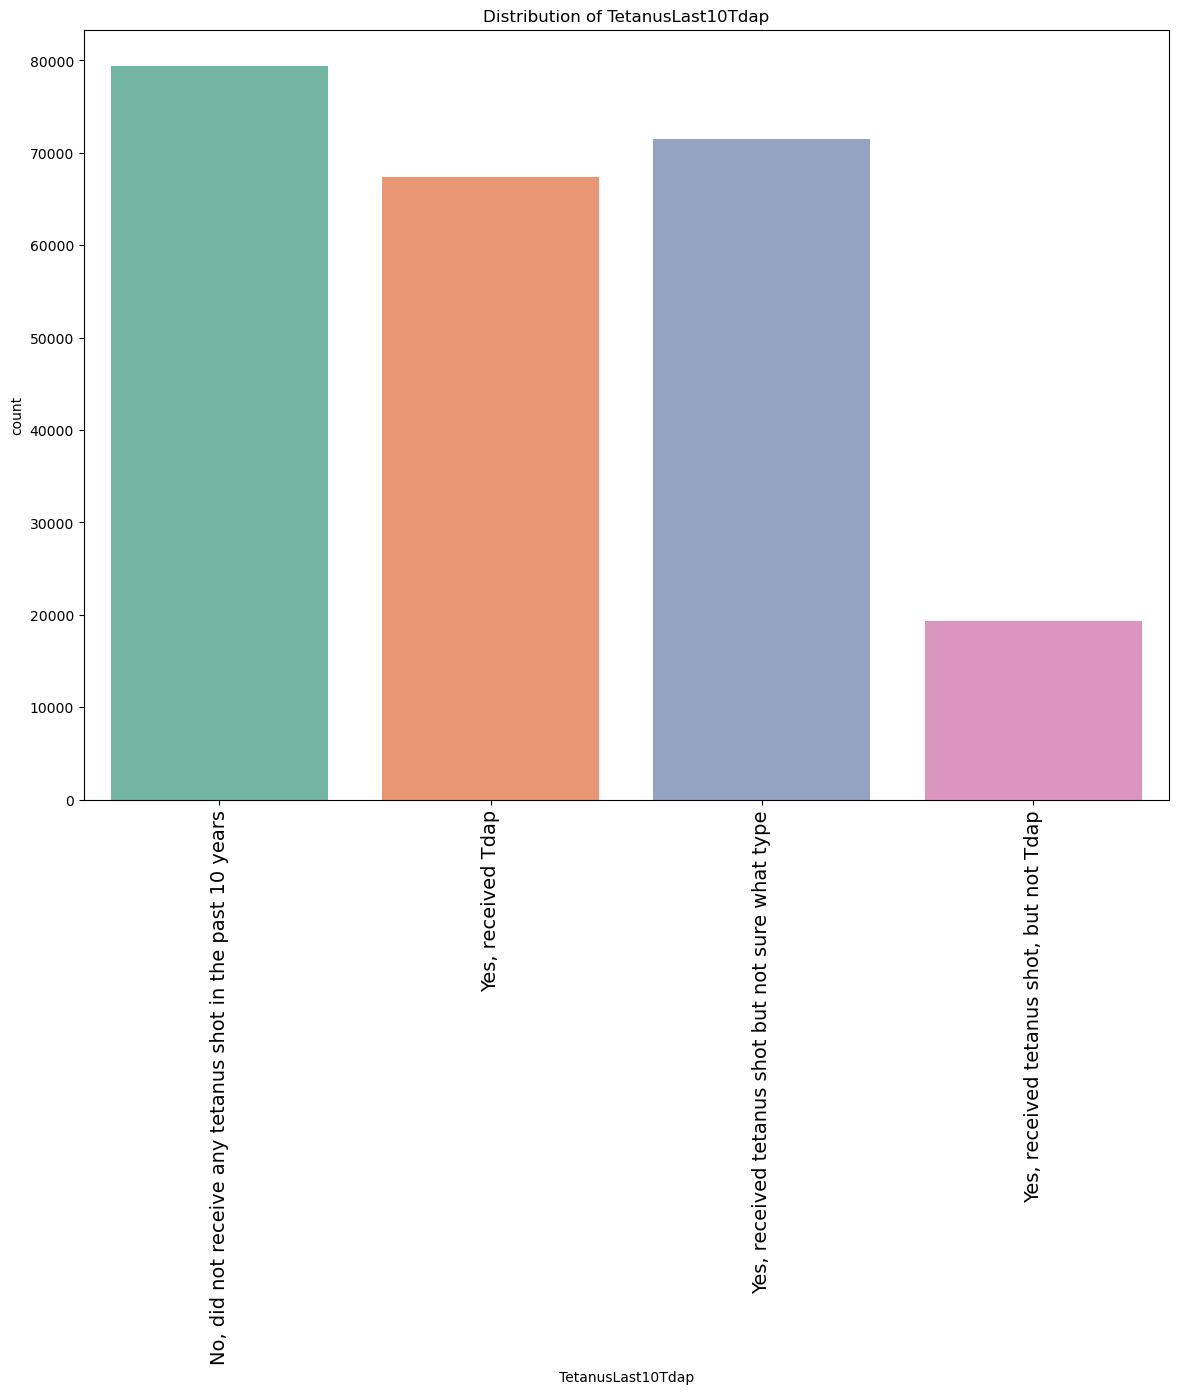

In [10]:
# Grafiklerin kaydedileceği graphs klasörü tanımlandı. 
output_dir = "graphs"
os.makedirs(output_dir, exist_ok=True)  # Klasör yoksa oluştur

# Kategorik değişkenlerin seçilmesi
categorical_columns = data.select_dtypes(include=['object']).columns

# Her bir kategorik değişken için dağılım grafiği oluşturuldu. 
for col in categorical_columns:
    plt.figure(figsize=(14, 10))  # Her değişken için ayrı bir grafik çizildi
    sns.countplot(data=data, x=col, palette="Set2")  # Dağılım grafiği çiziyoruz
    plt.title(f"Distribution of {col}", fontsize=12)  # Grafiğe başlık ekleniyor
    
    # x eksenindeki yazıların okunması için rotasyonları atandı.
    if col in ["Generation", "GeneralHealth", "Sex"]:
        plt.xticks(rotation=0, fontsize=14)
    elif col == "AgeCategory":
        plt.xticks(rotation=45, fontsize=14)
    else:
        plt.xticks(rotation=90, fontsize=14)
    
    # Grafiği kaydetme
    output_path = os.path.join(output_dir, f"{col}_distribution.png")  # Dosya adı ve yol oluşturuluyor
    plt.savefig(output_path, bbox_inches="tight", dpi=300)  # Grafiği yüksek çözünürlükte kaydet
    
    plt.show()


In [11]:
# Sürekli değişkenlerin özet istatistikleri
print(data.describe())

       HeightInMeters  WeightInKilograms            BMI  HadHeartAttack  \
count   237571.000000      237571.000000  237571.000000   237571.000000   
mean         1.704987          83.669551      28.692279        0.055567   
std          0.106776          21.361379       6.528254        0.229083   
min          0.910000          28.120001      12.020000        0.000000   
25%          1.630000          68.040001      24.280001        0.000000   
50%          1.700000          81.650002      27.459999        0.000000   
75%          1.780000          95.250000      31.900000        0.000000   
max          2.410000         292.570007      97.650002        1.000000   

           HadAngina      HadStroke      HadAsthma  HadSkinCancer  \
count  237571.000000  237571.000000  237571.000000  237571.000000   
mean        0.061527       0.041777       0.148532       0.085221   
std         0.240295       0.200080       0.355628       0.279211   
min         0.000000       0.000000       0.0000

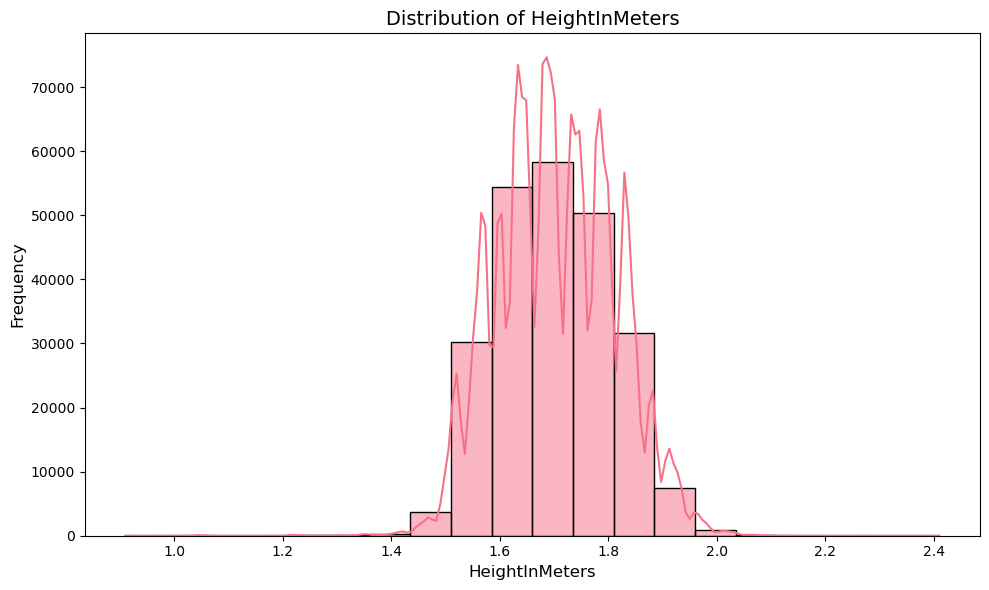

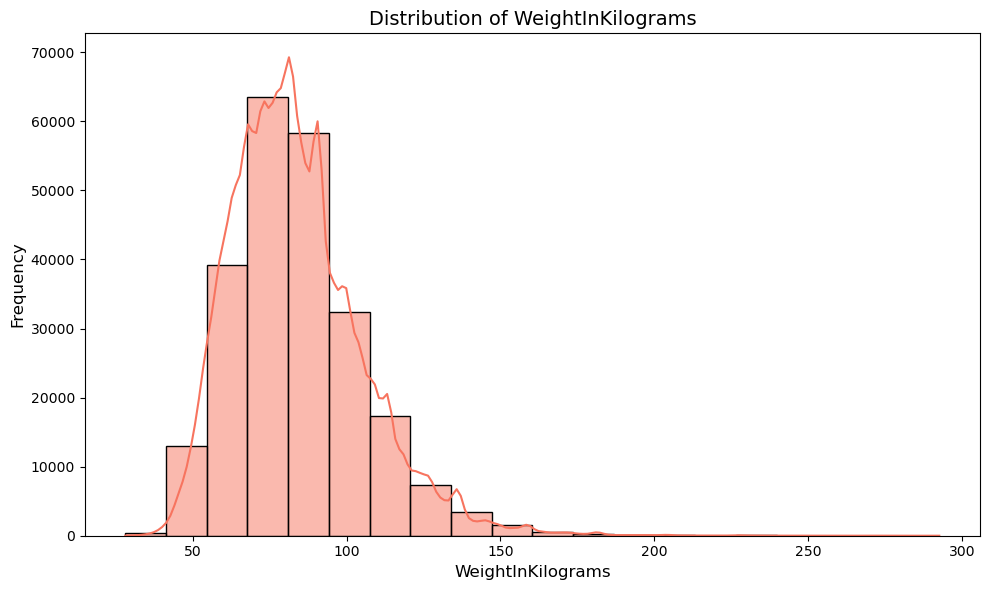

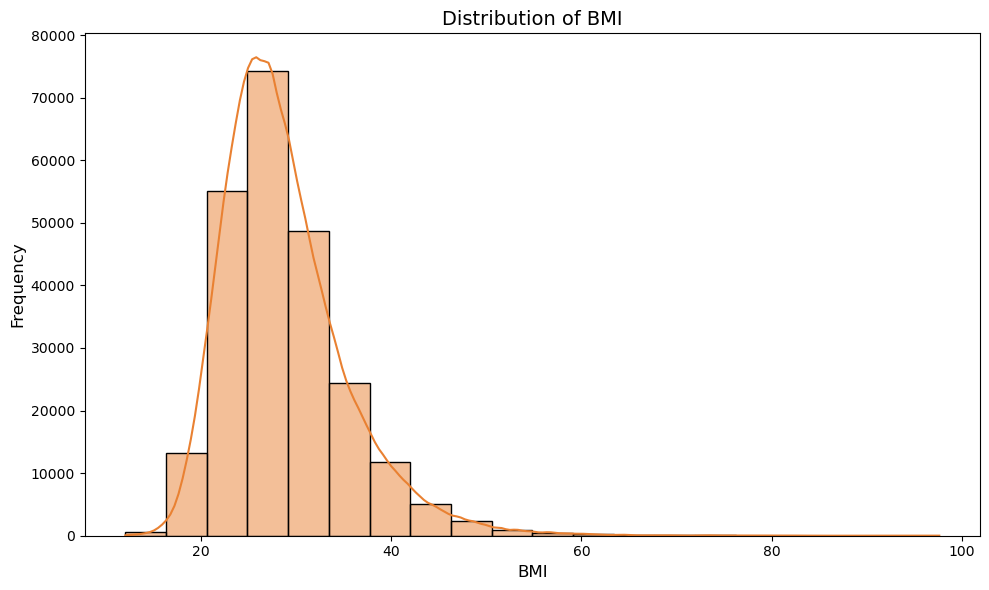

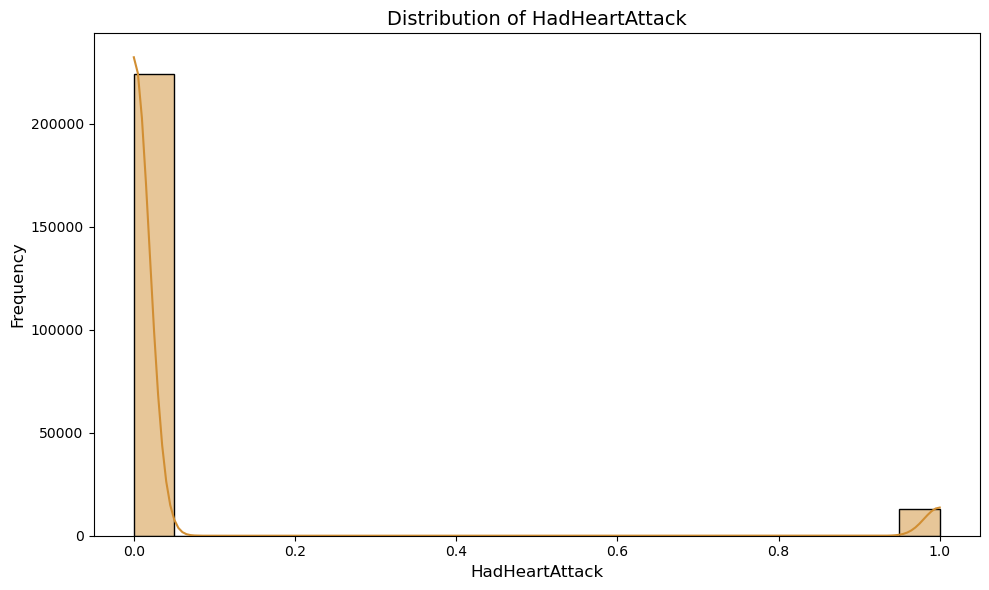

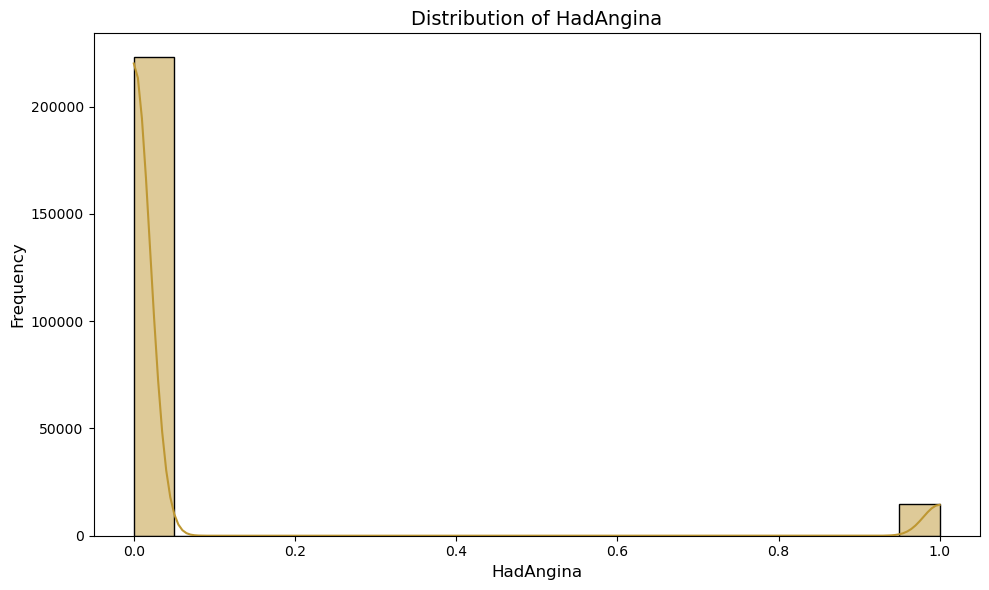

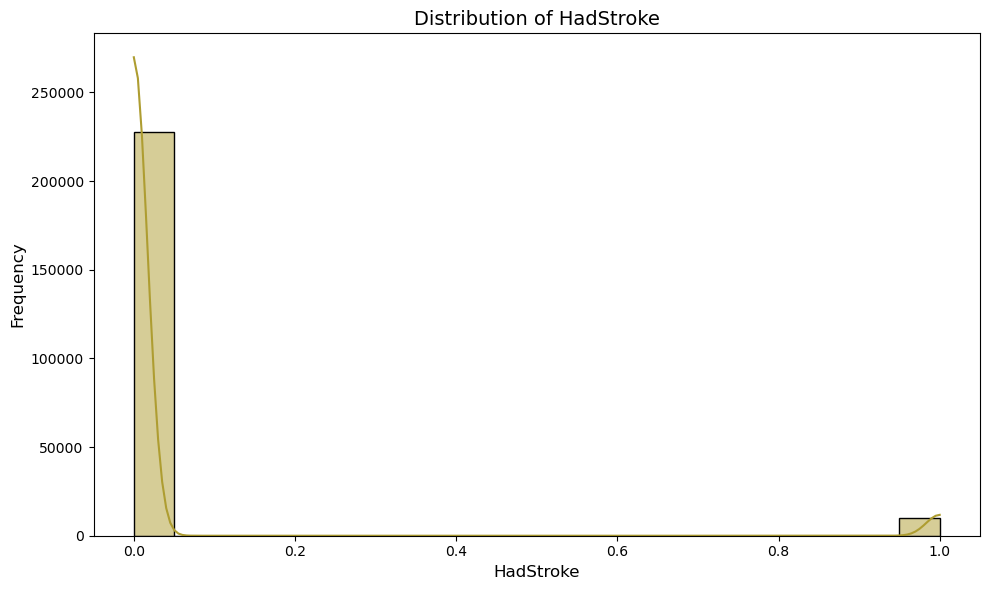

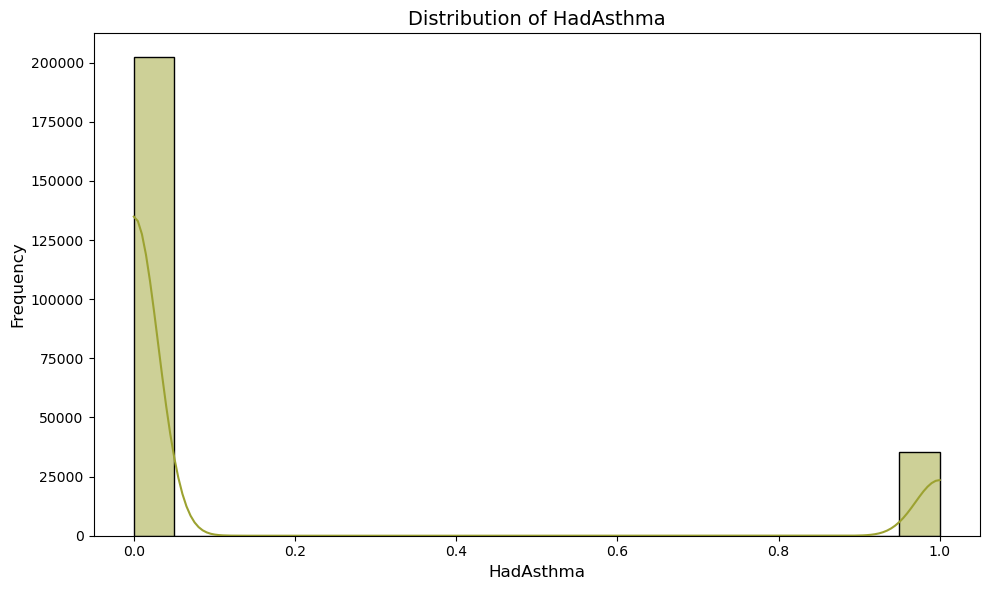

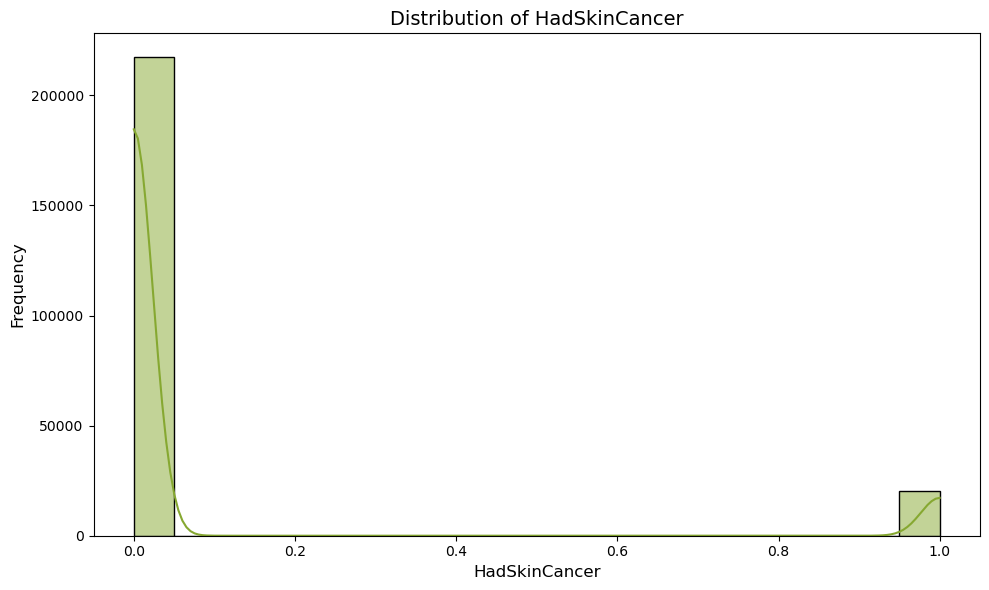

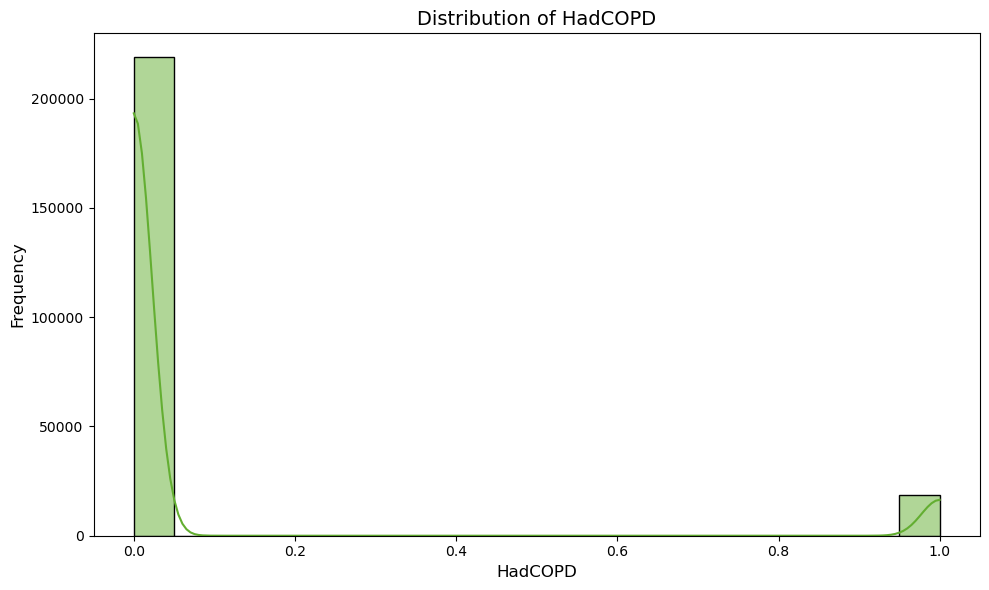

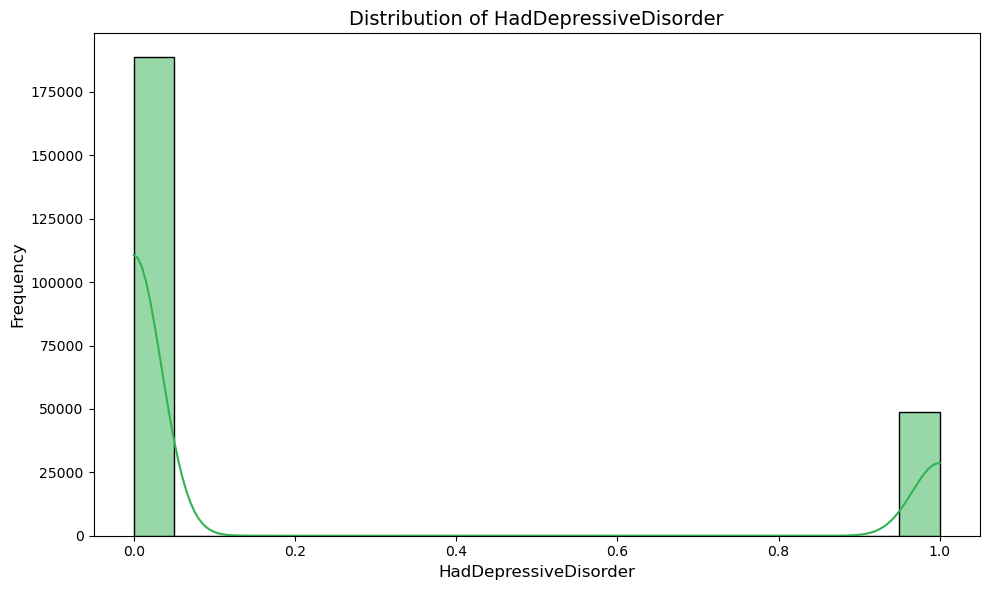

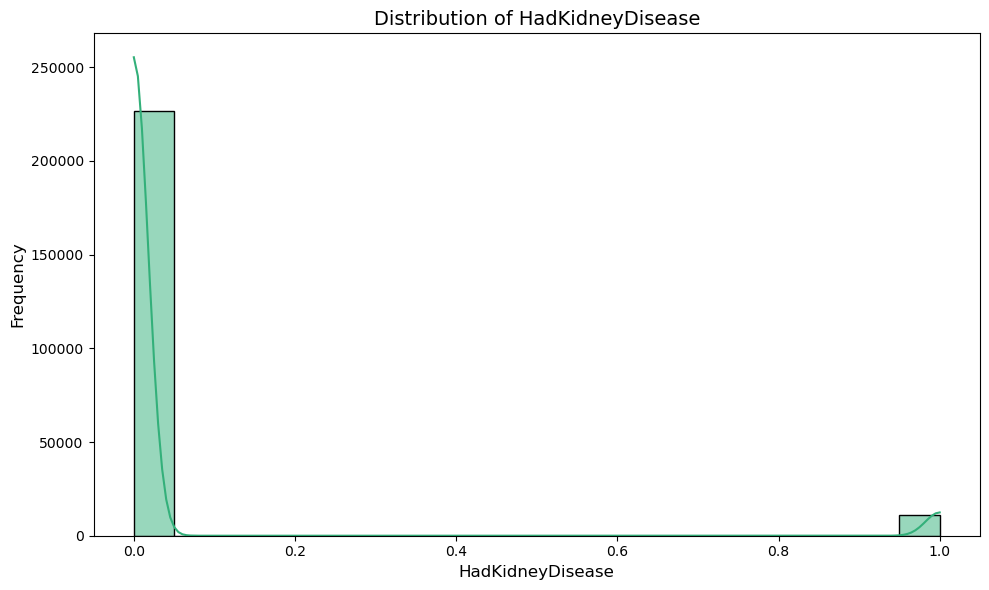

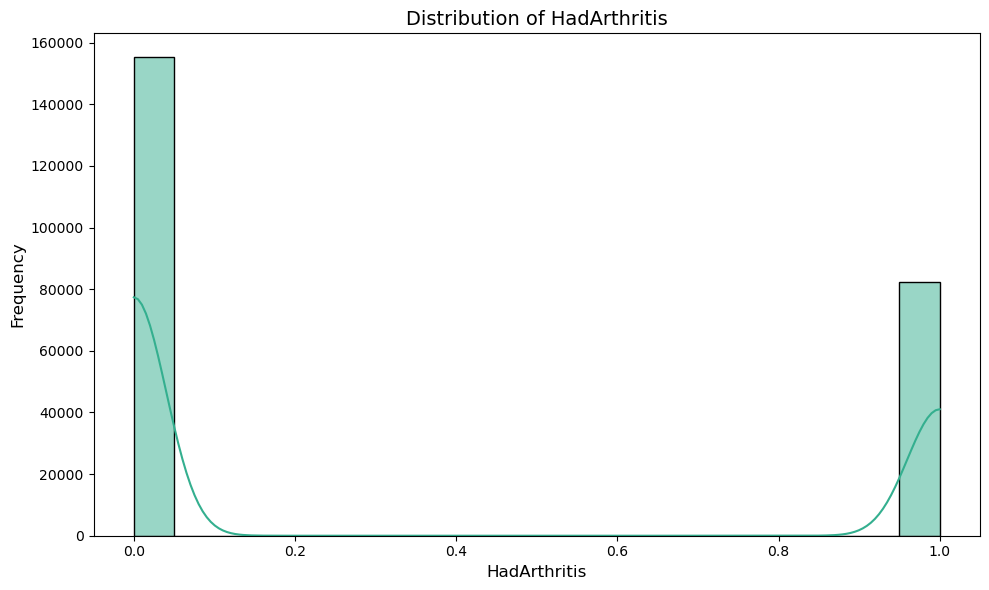

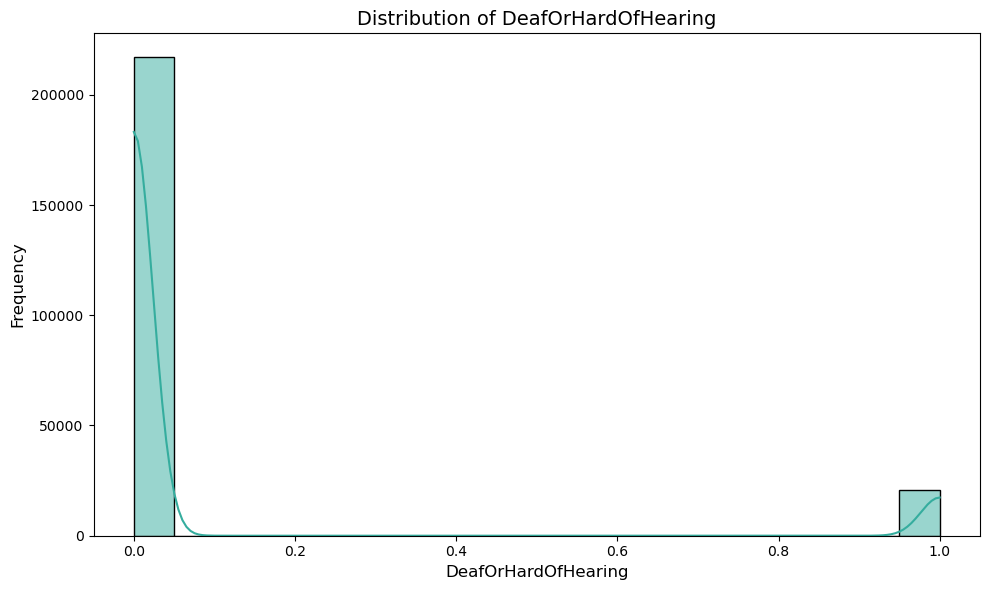

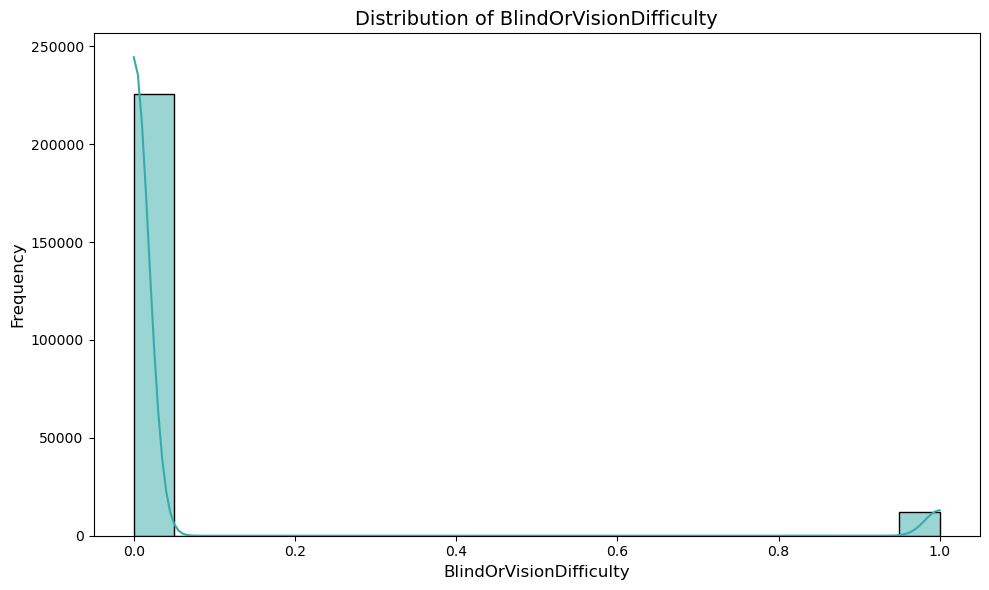

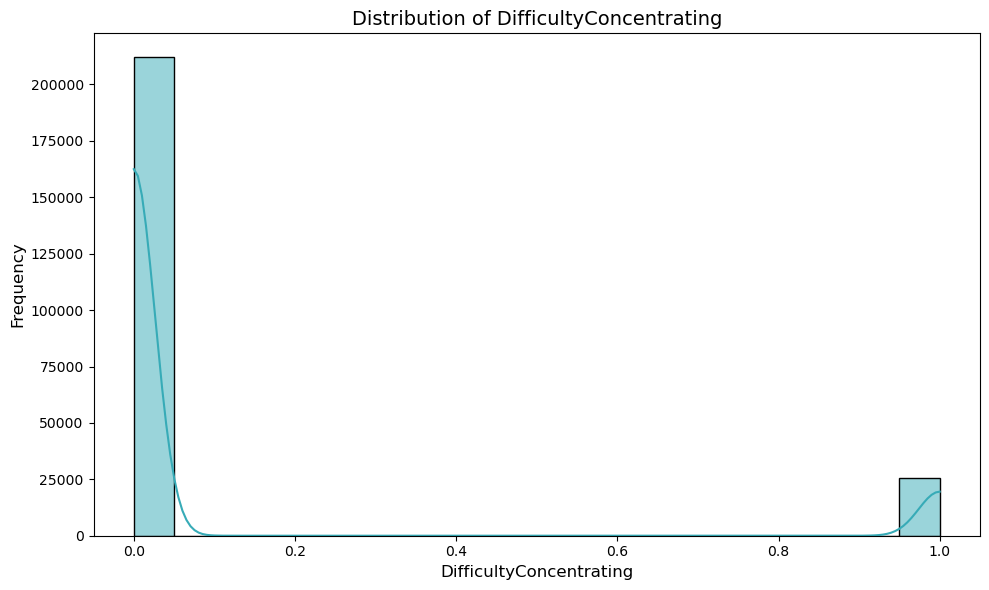

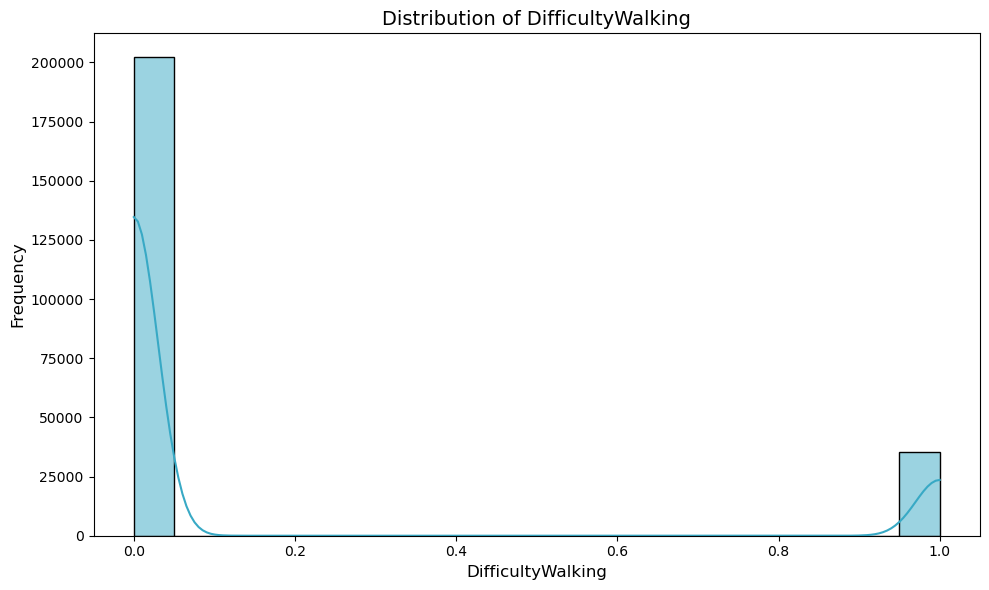

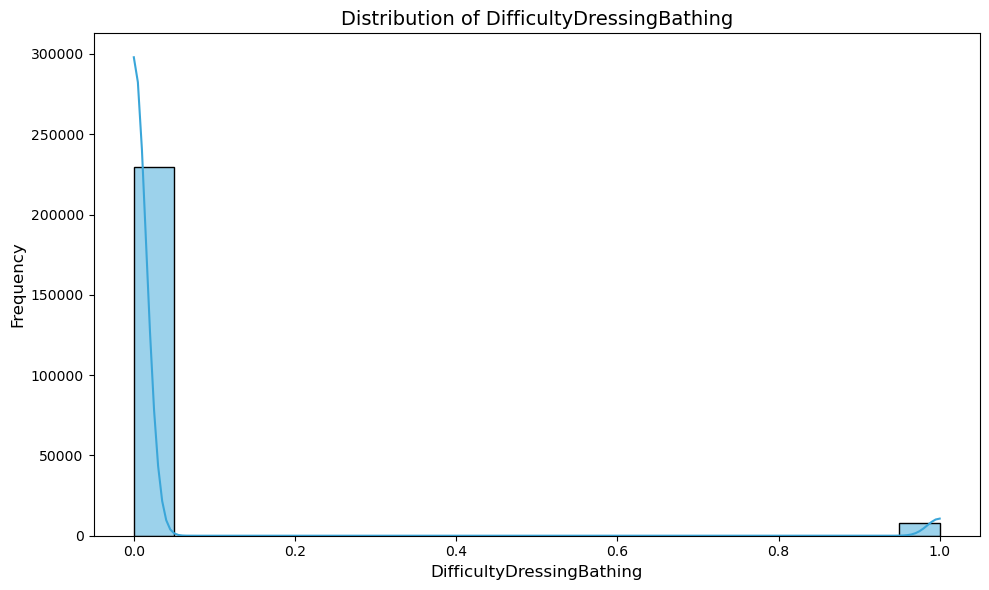

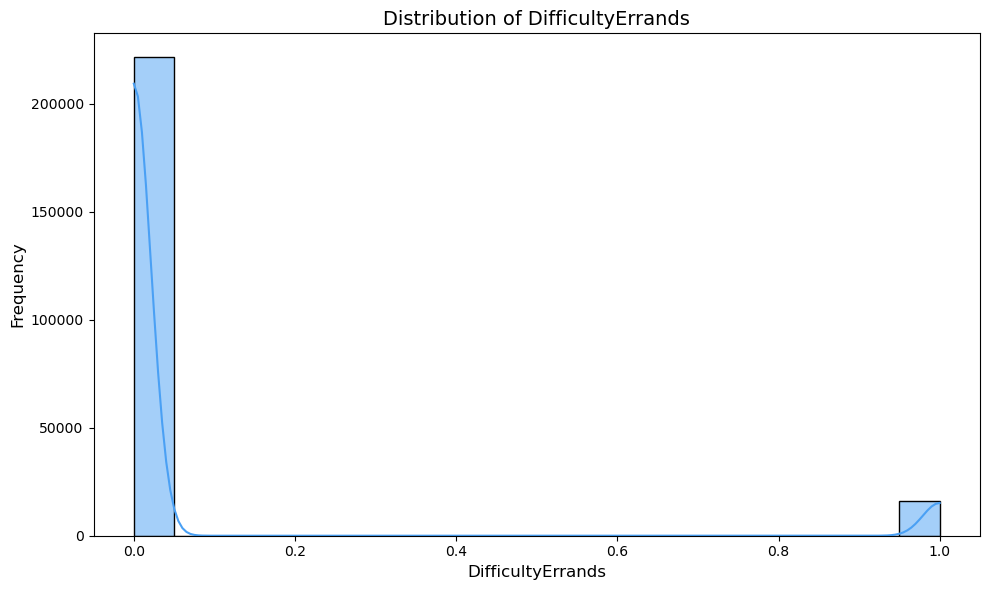

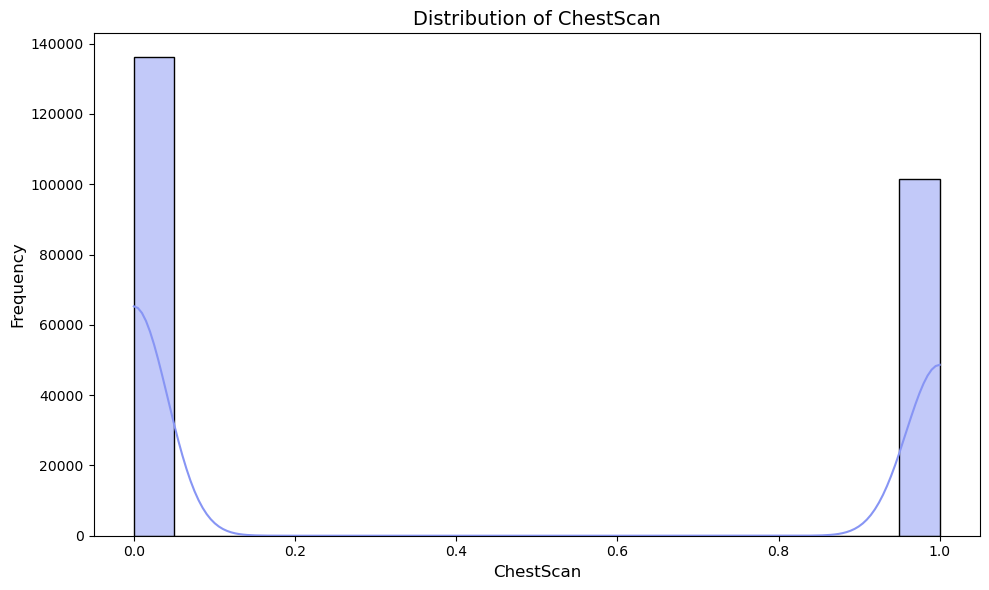

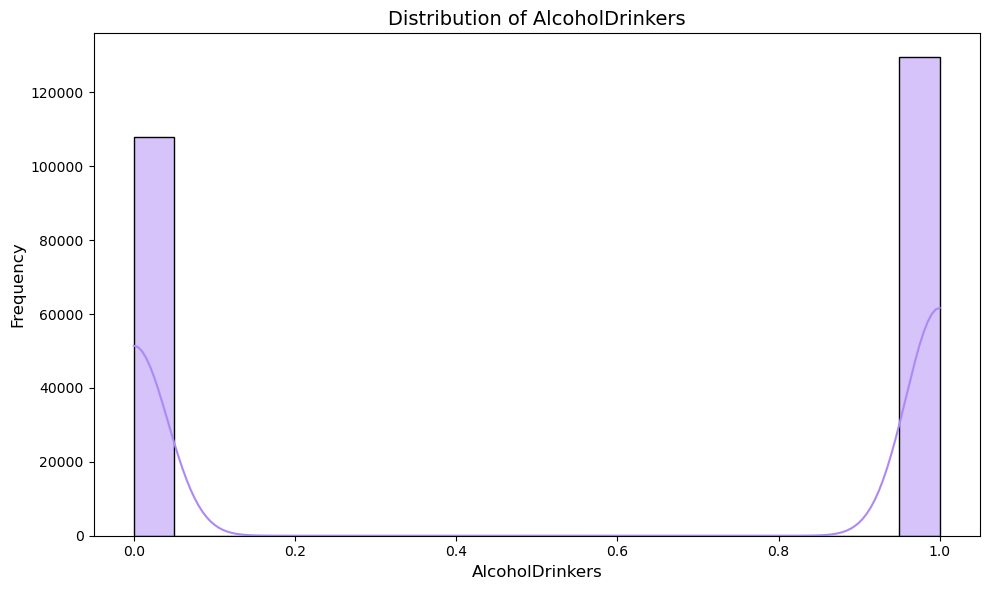

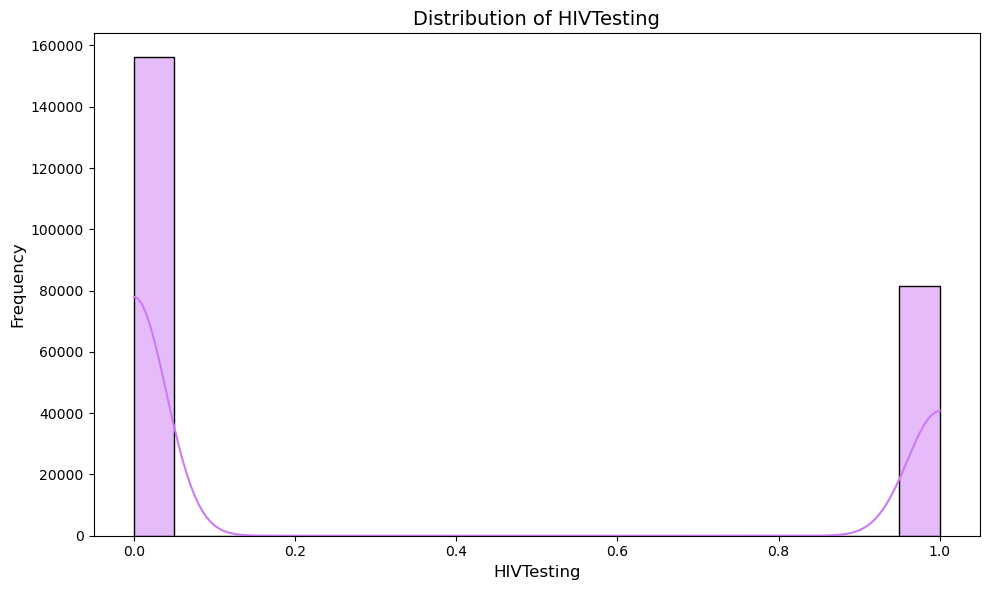

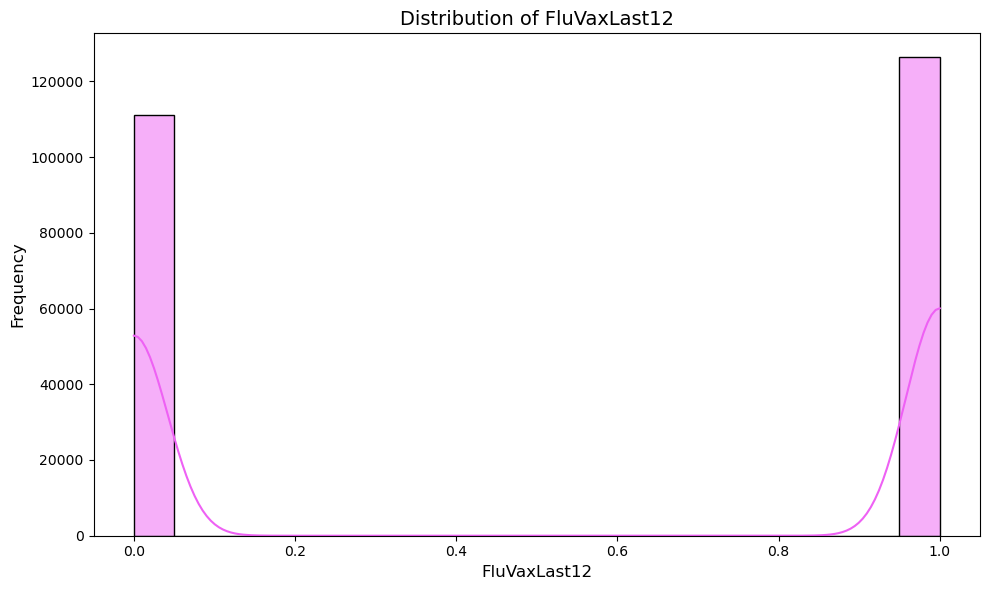

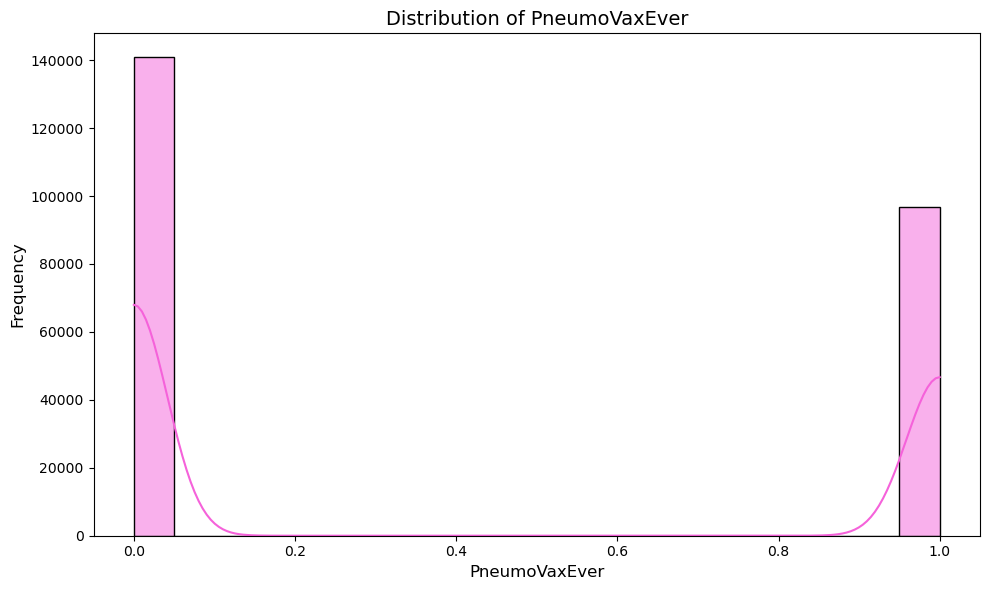

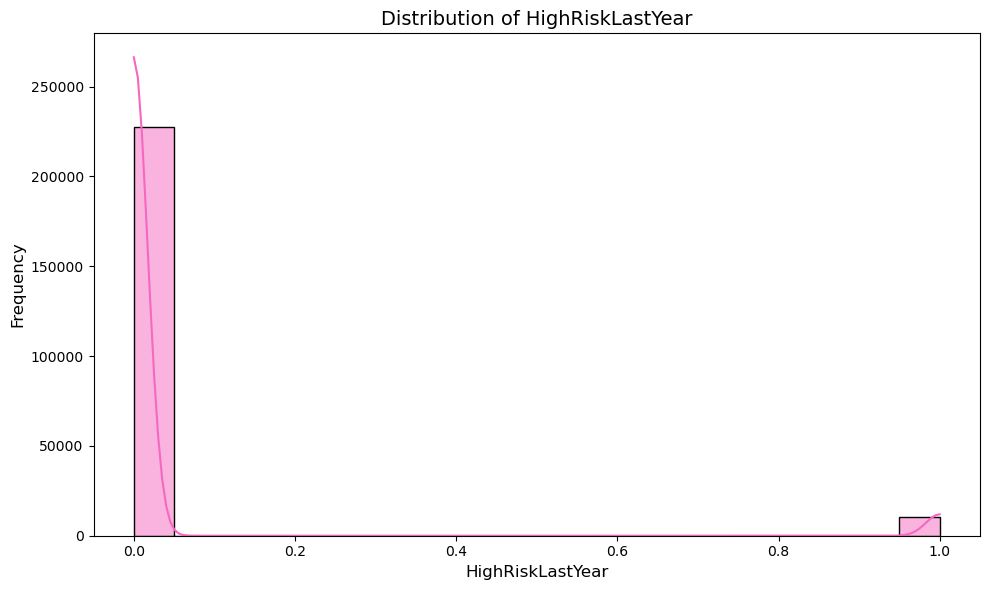

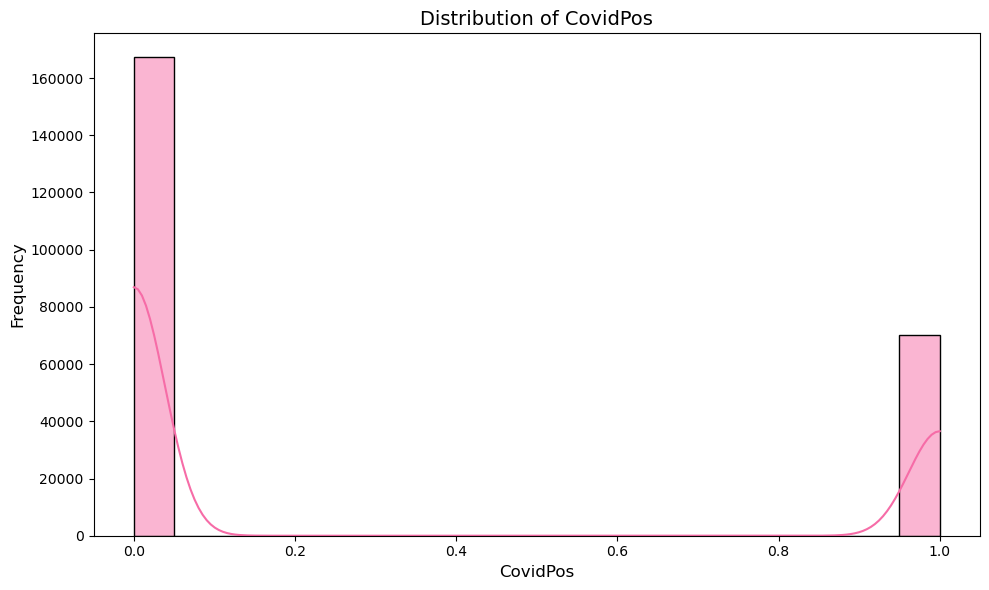

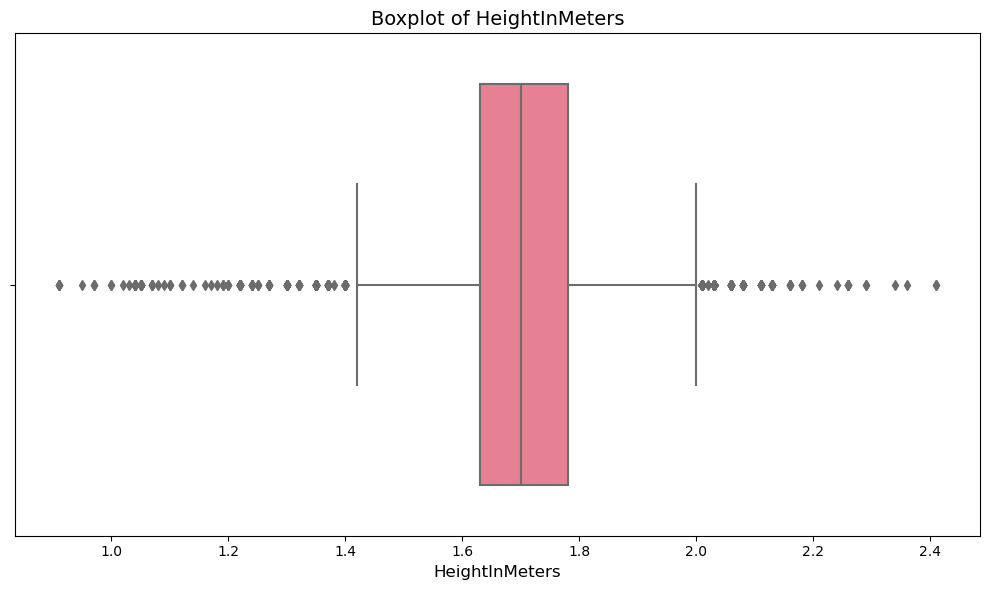

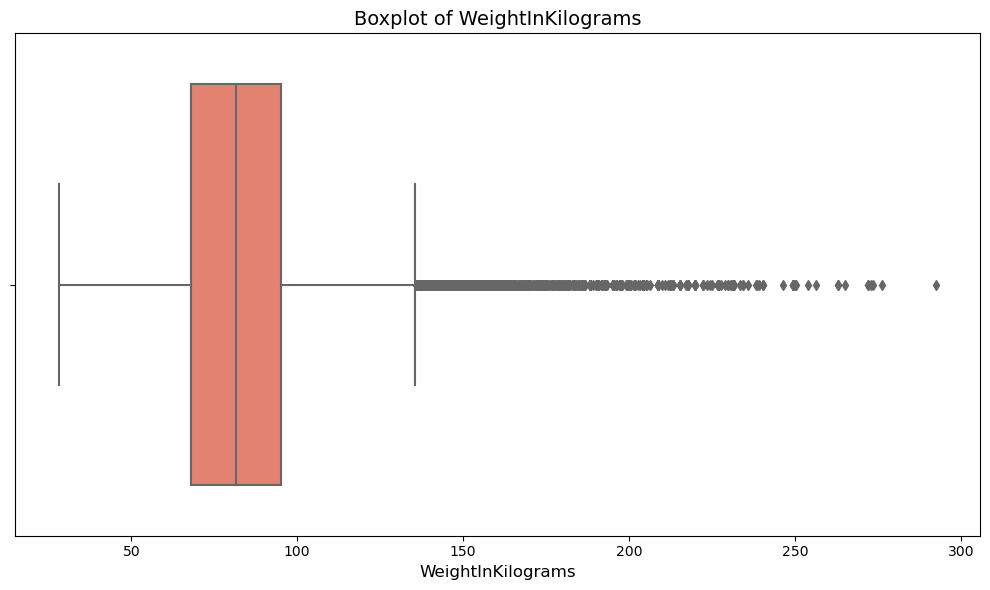

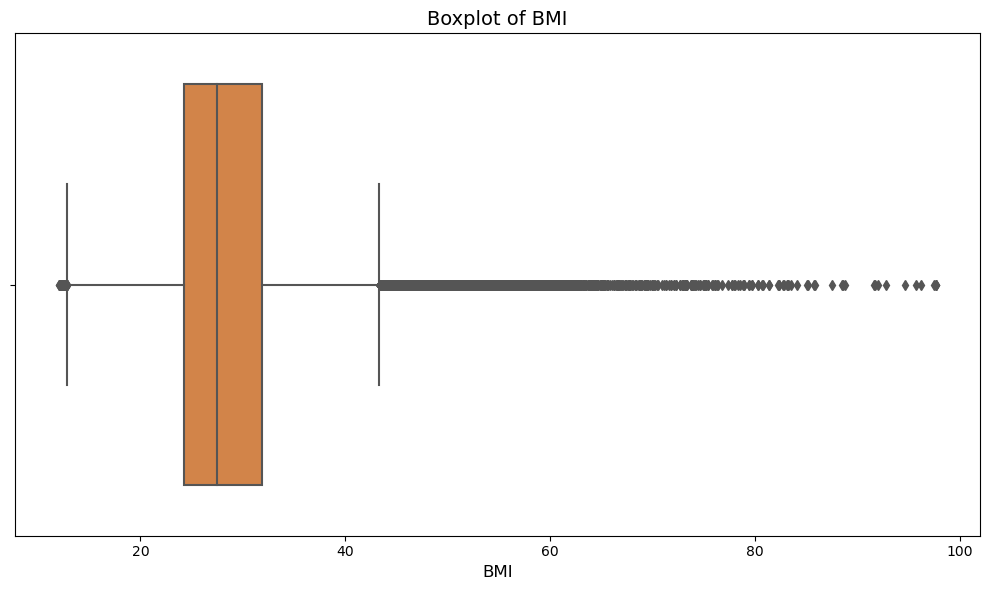

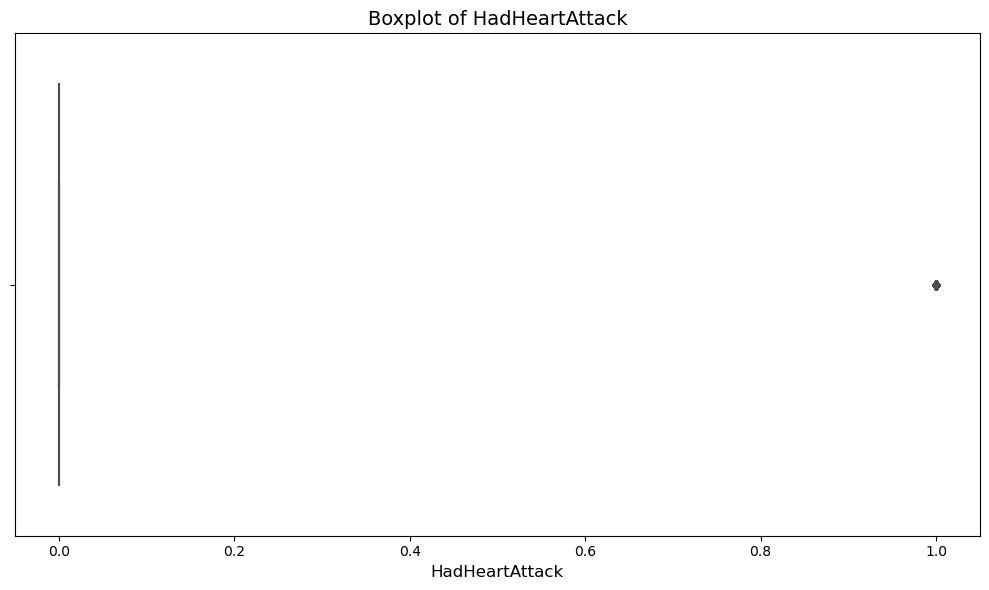

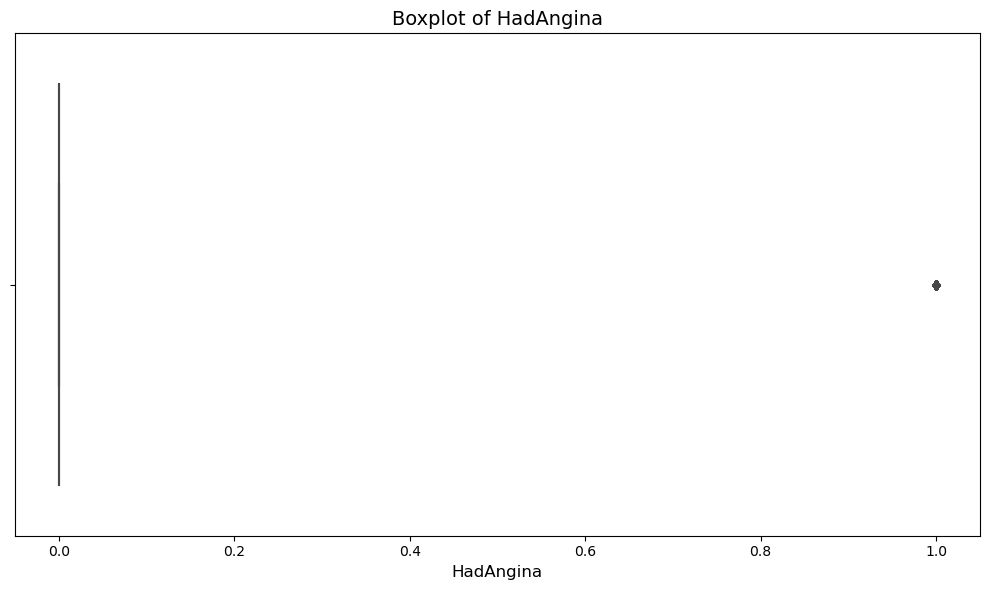

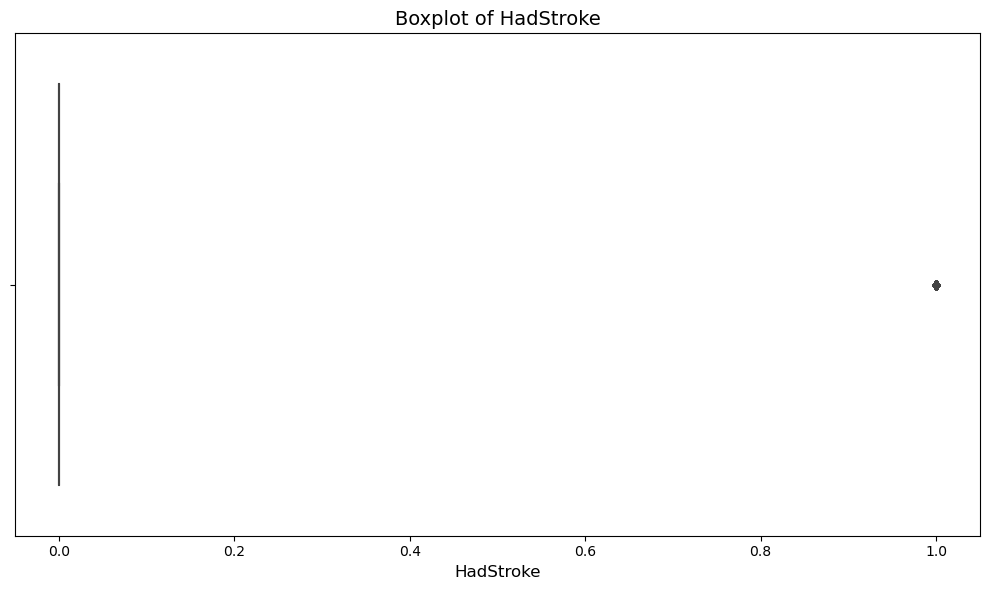

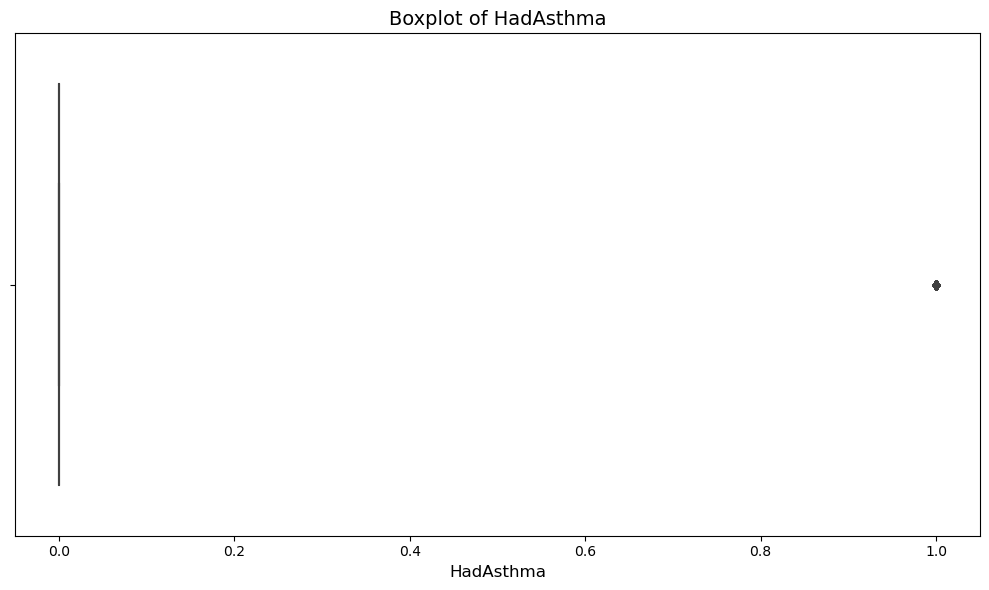

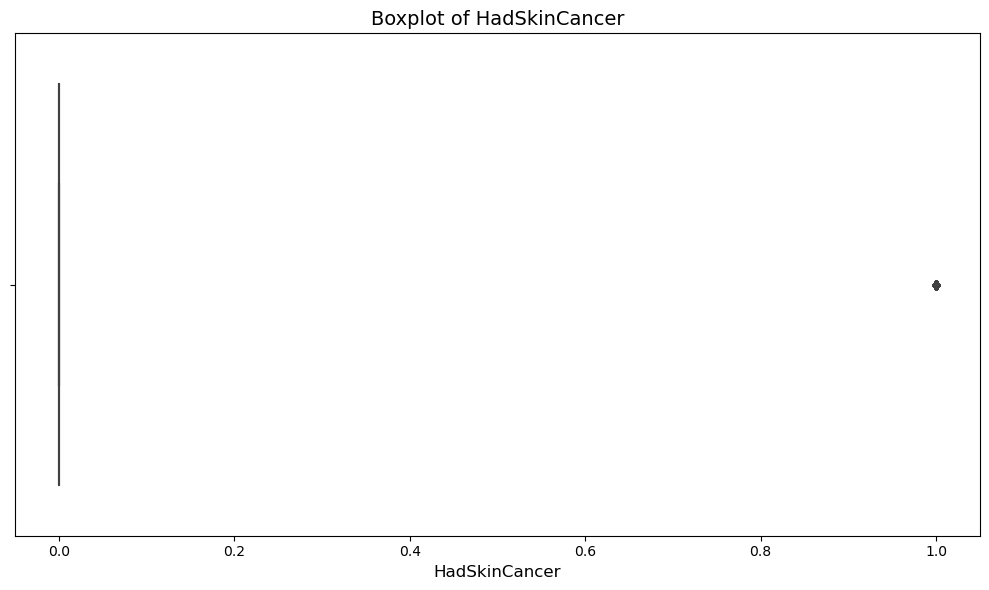

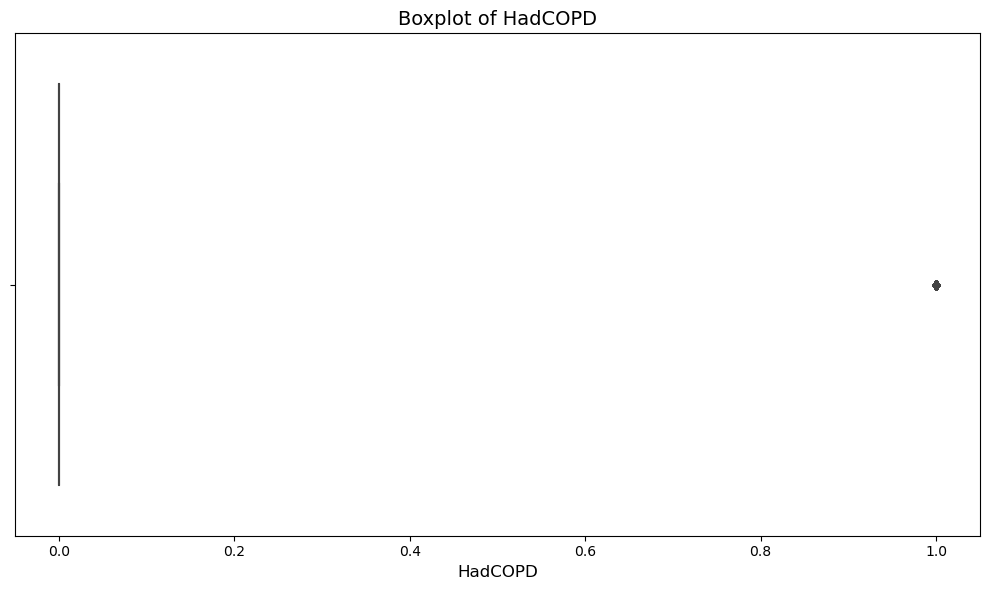

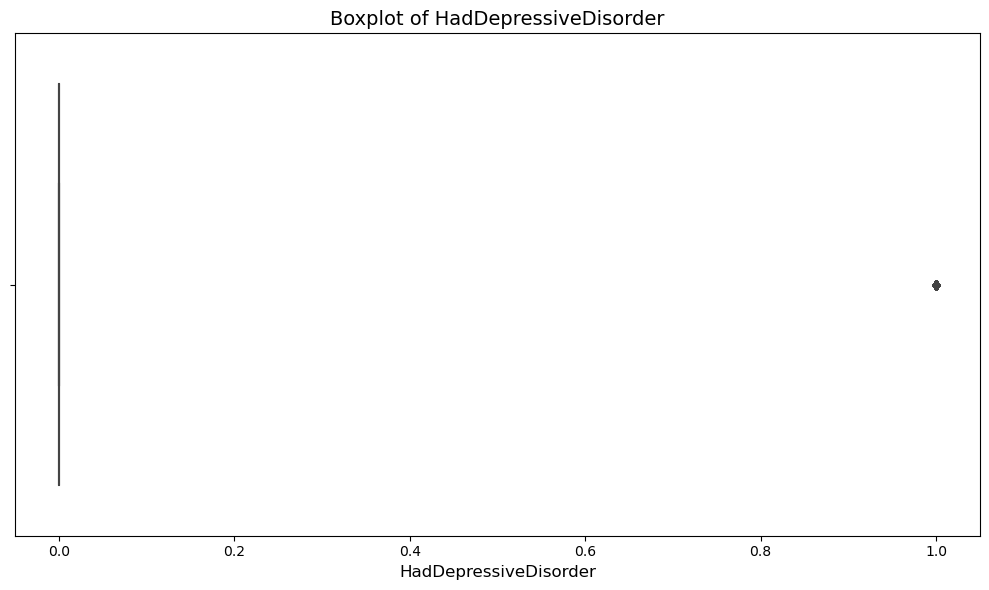

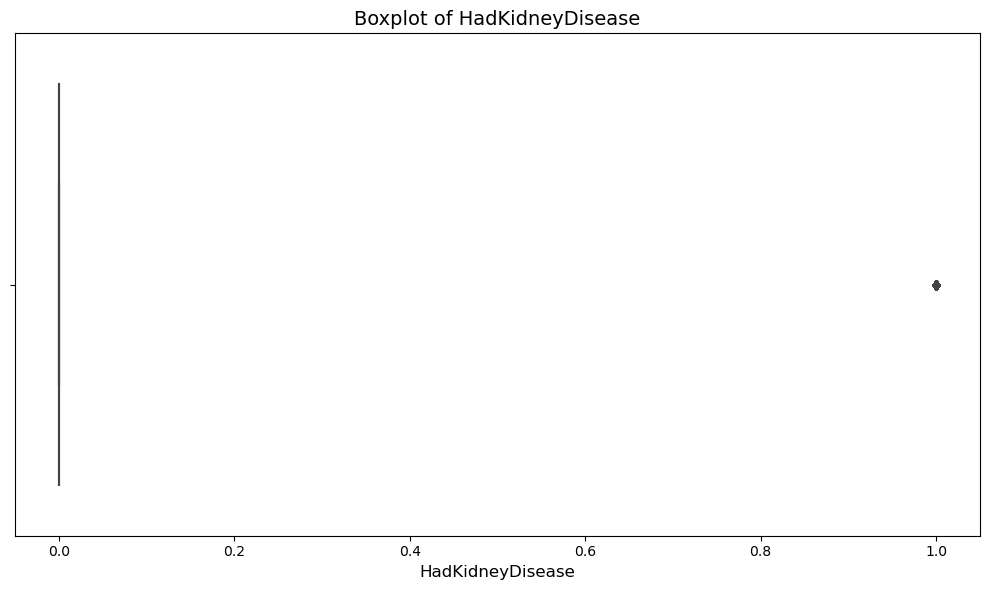

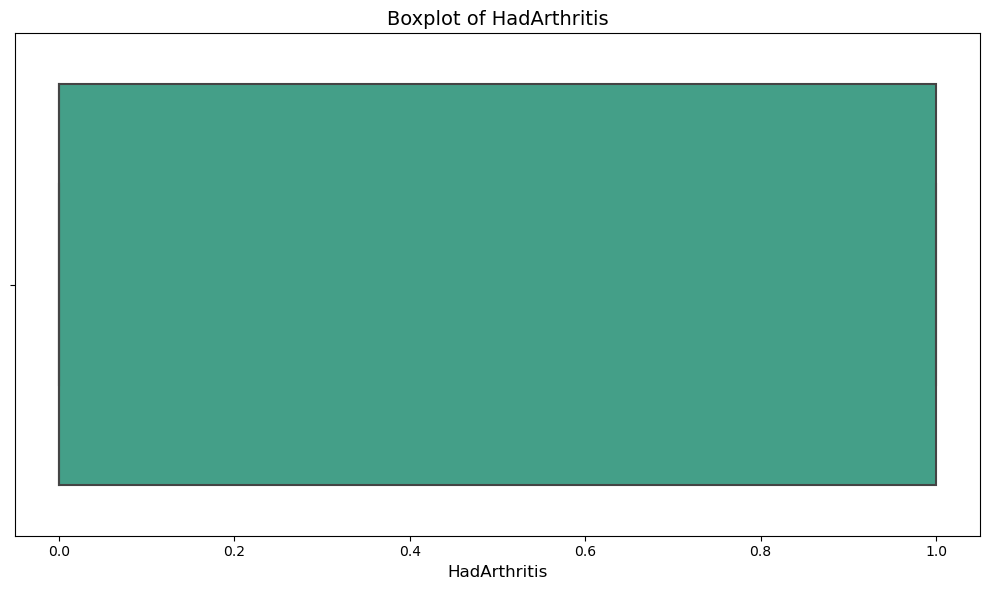

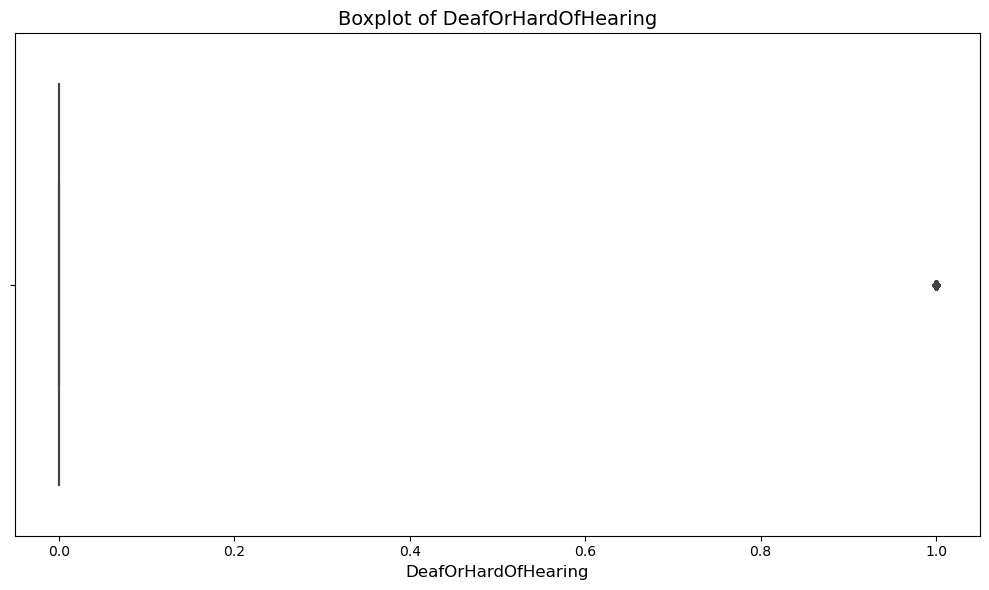

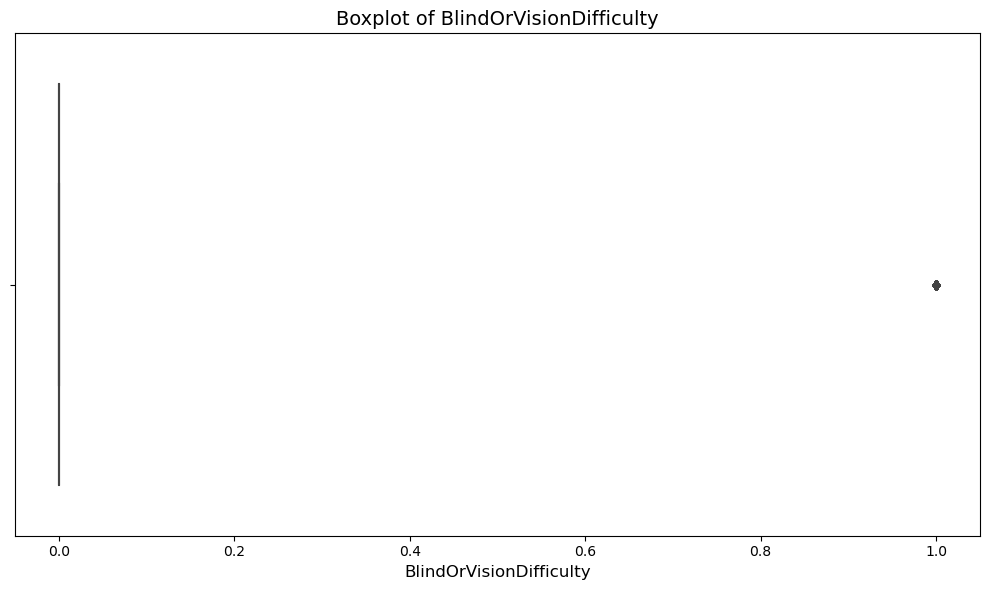

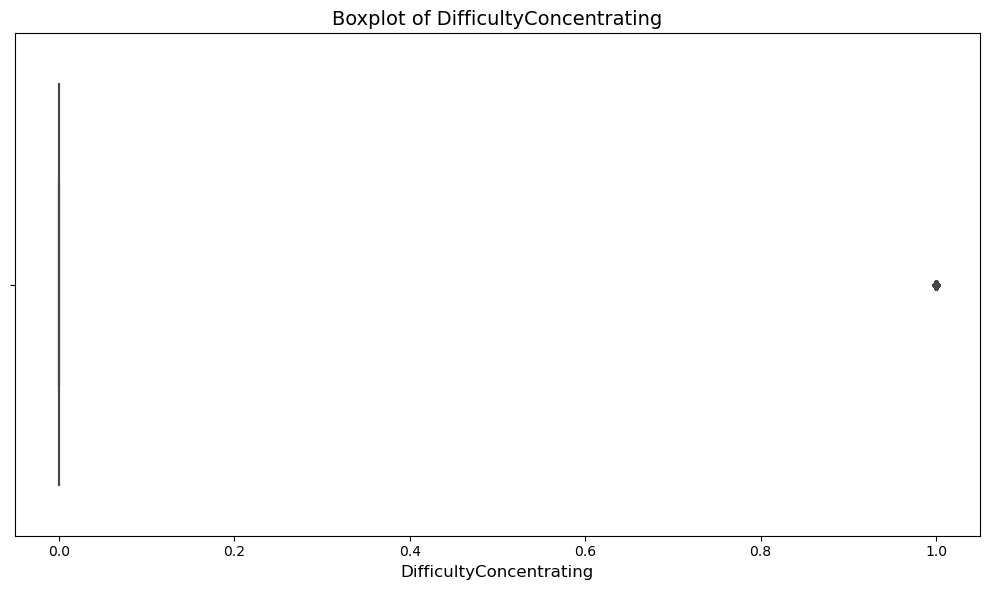

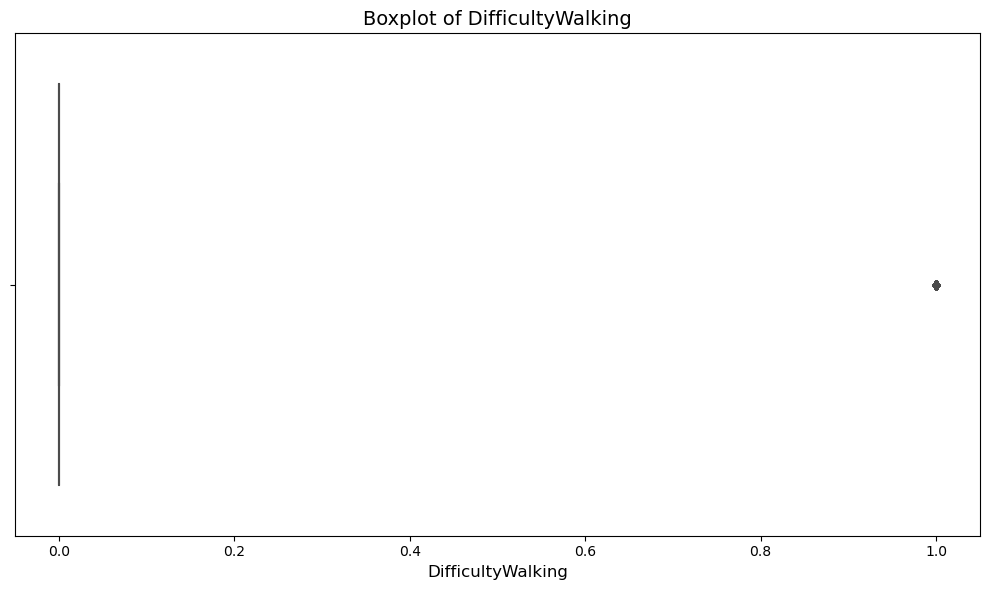

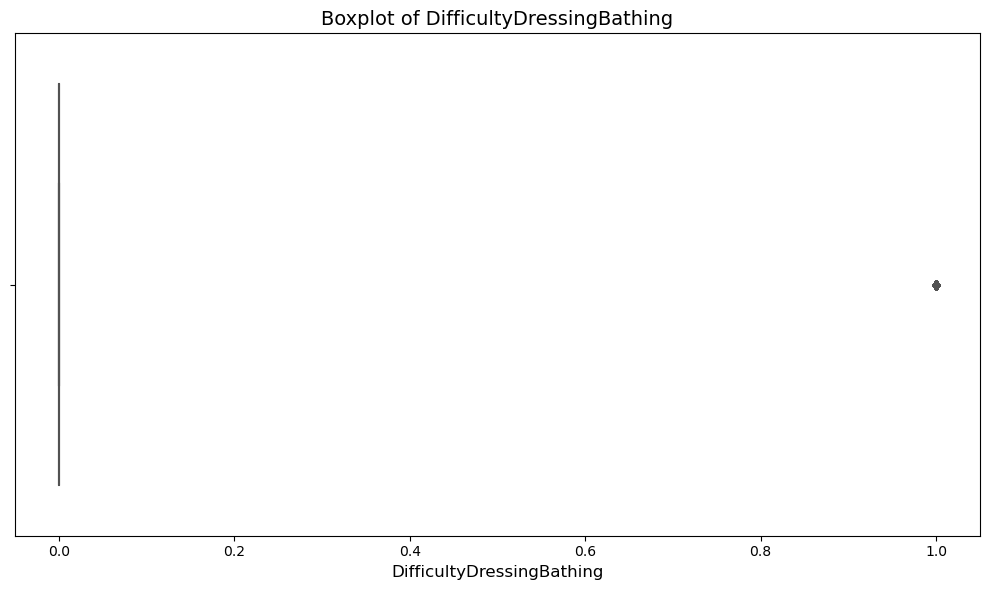

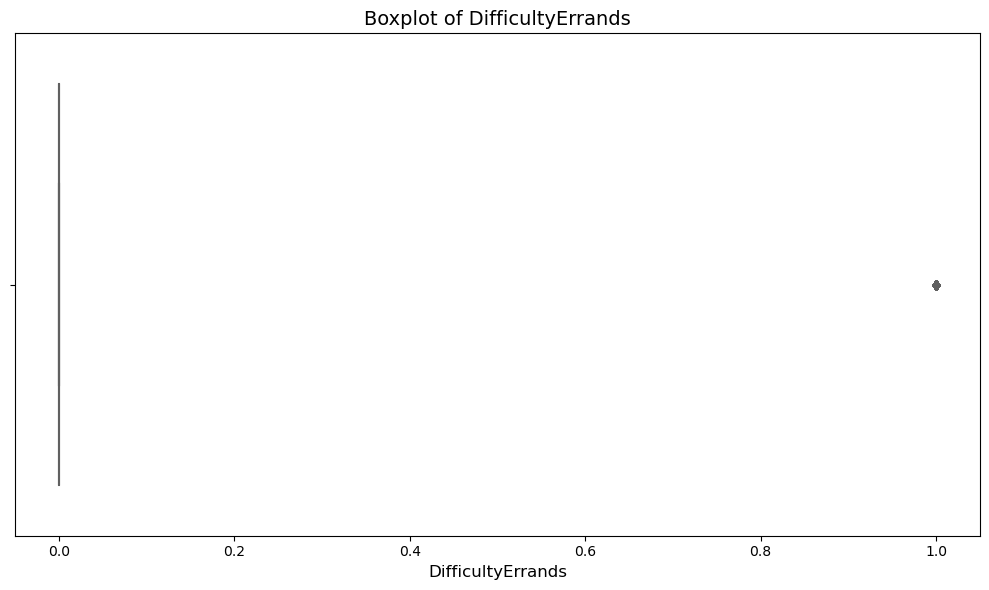

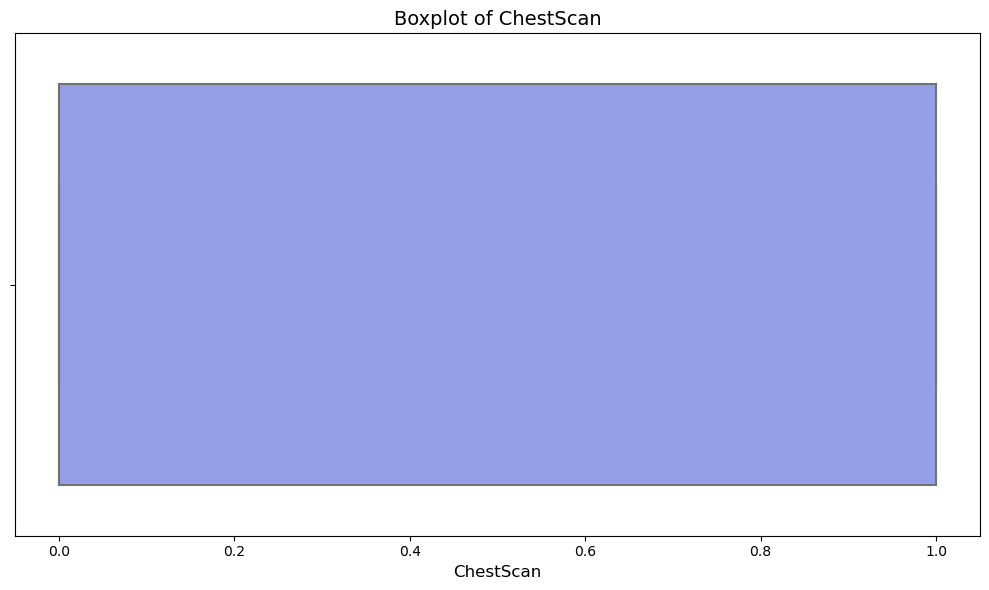

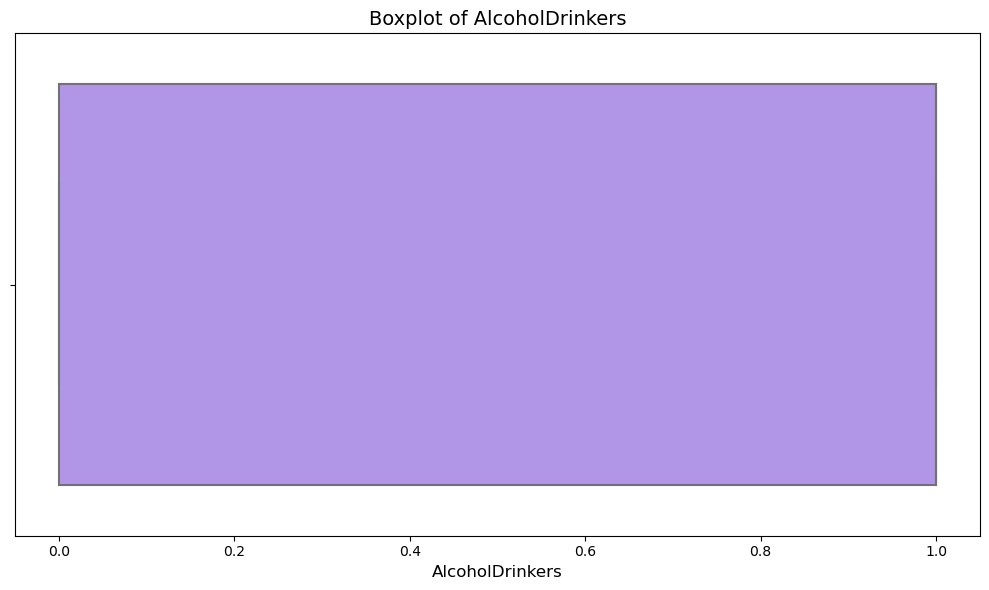

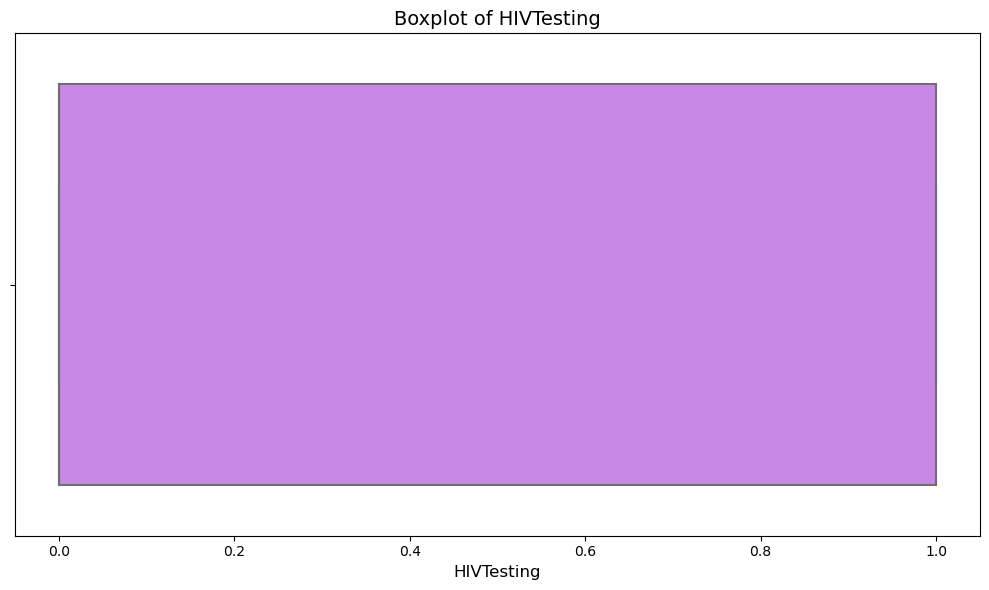

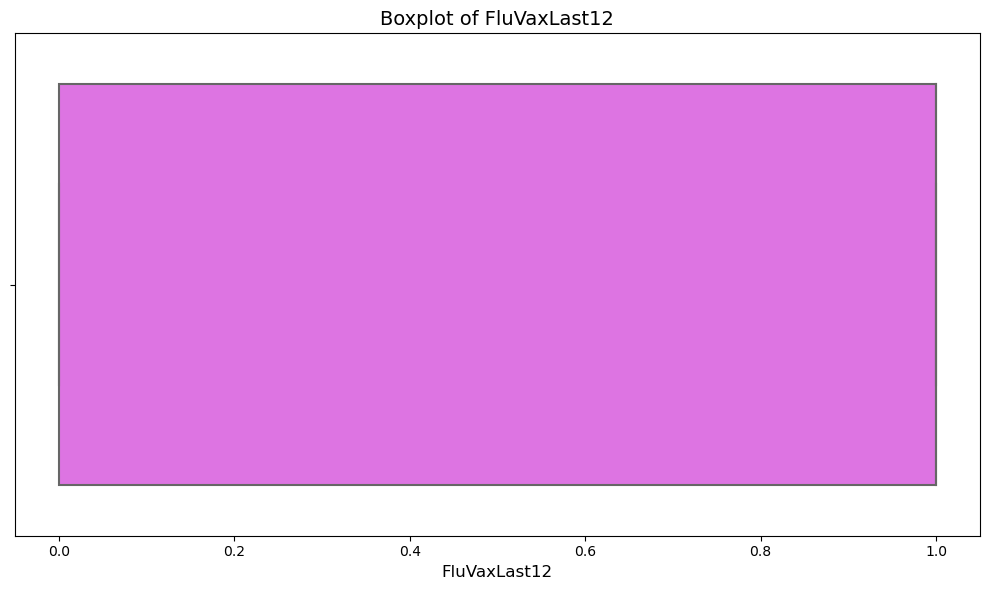

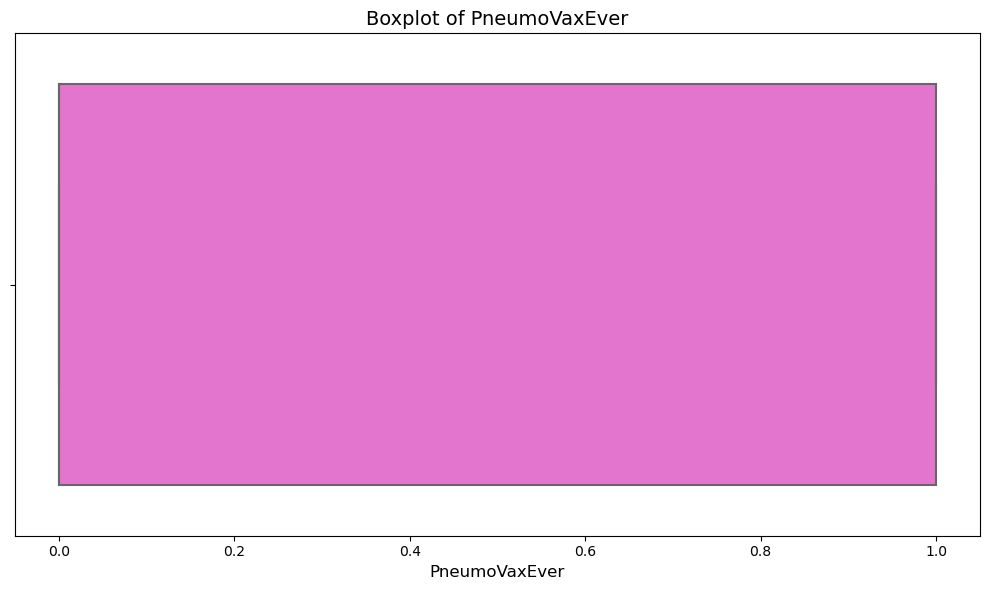

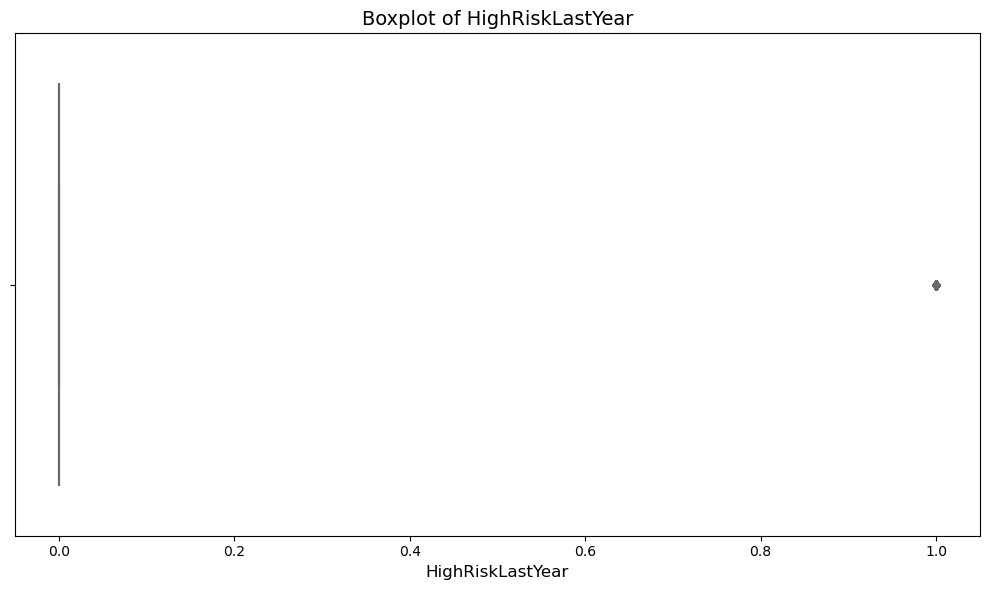

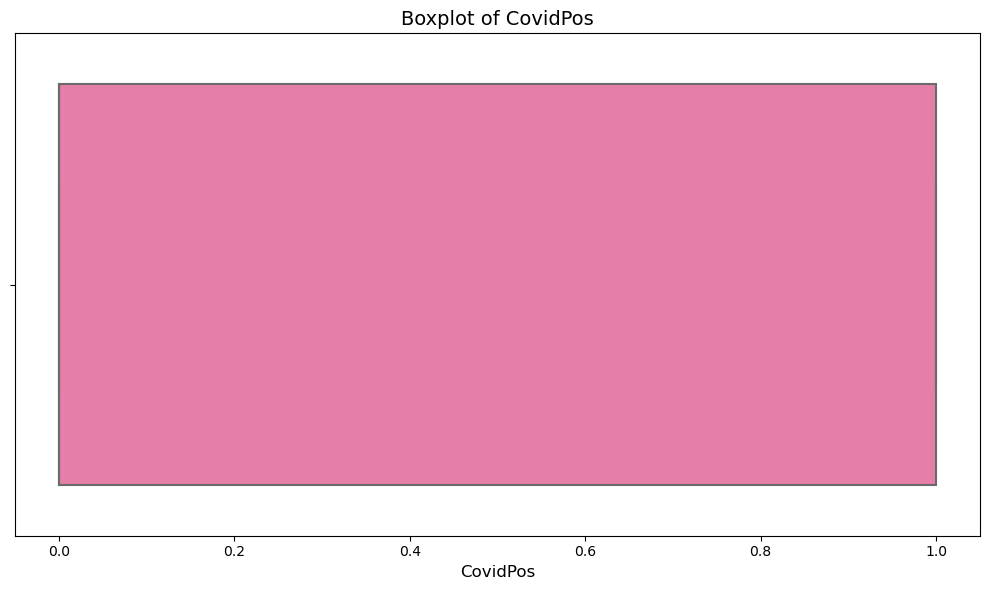

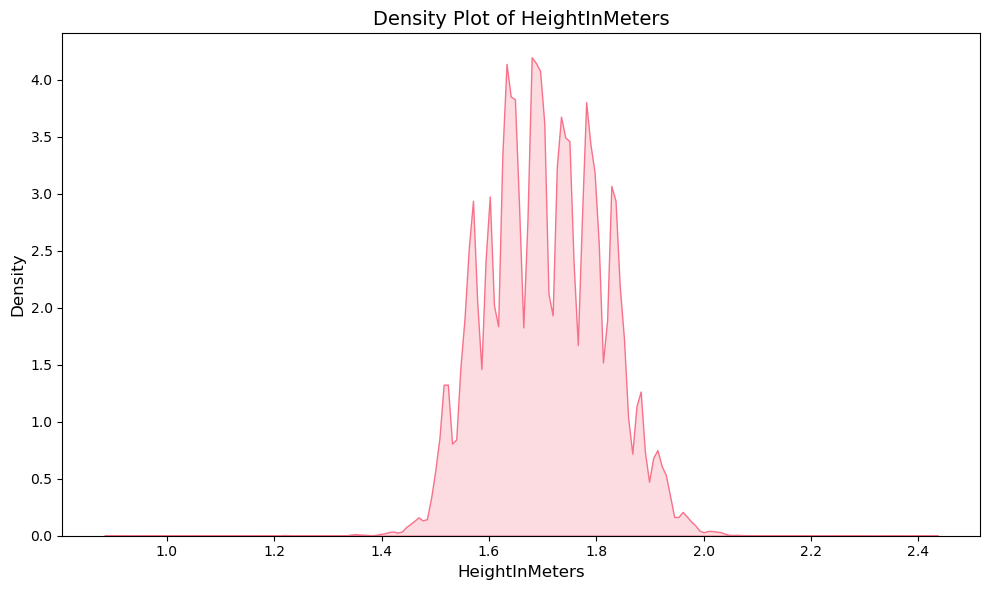

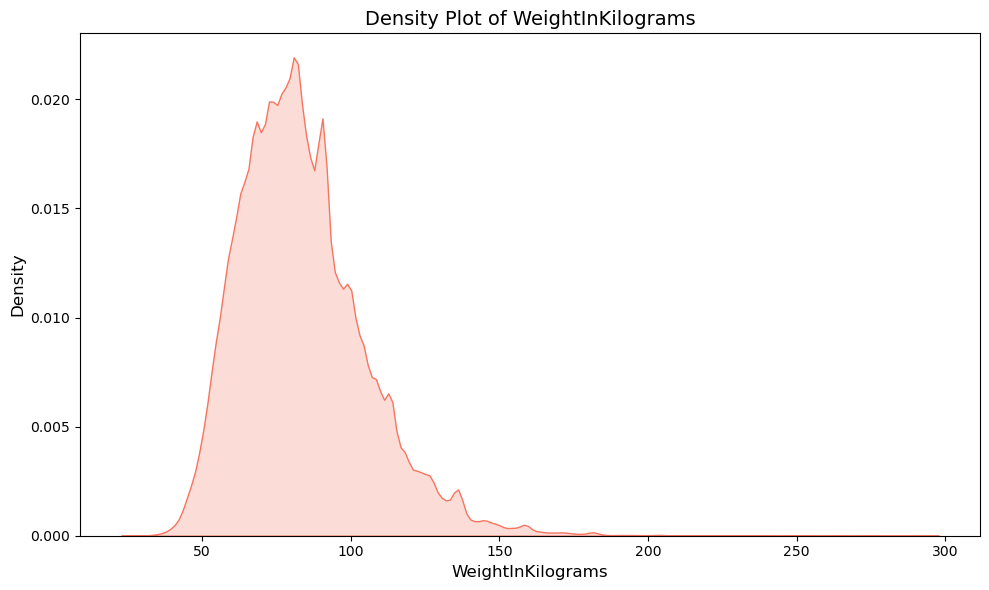

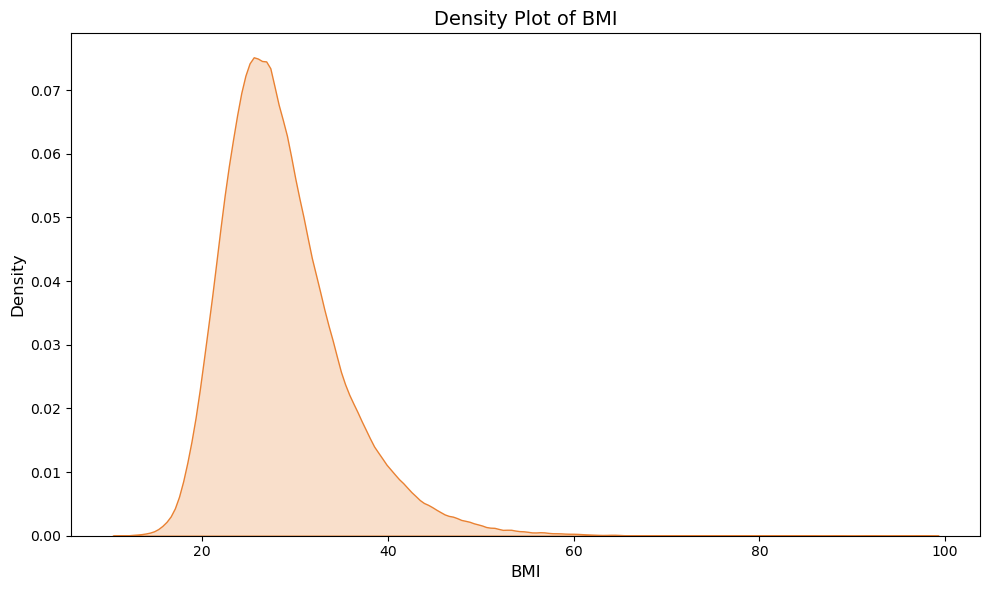

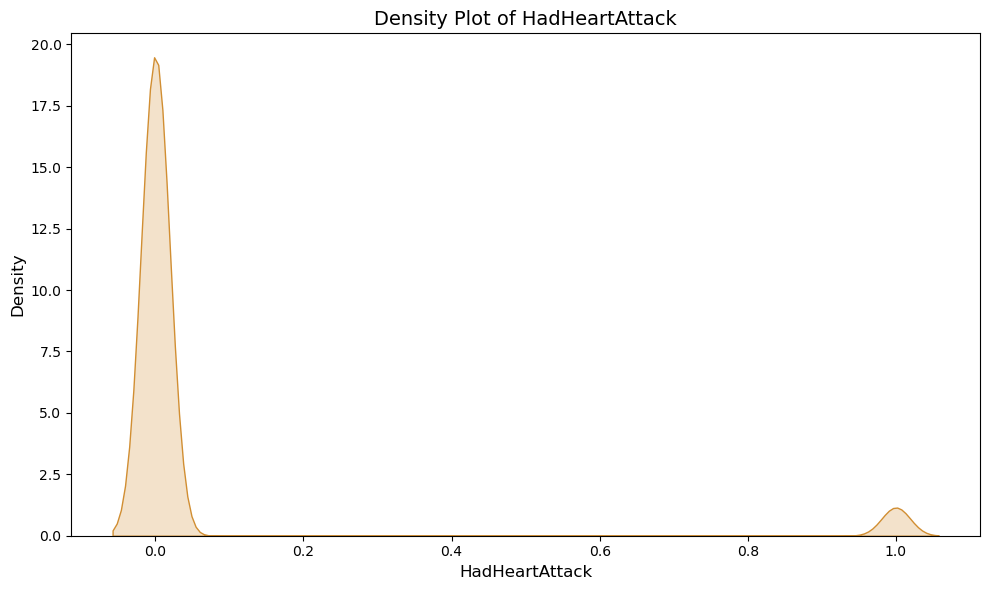

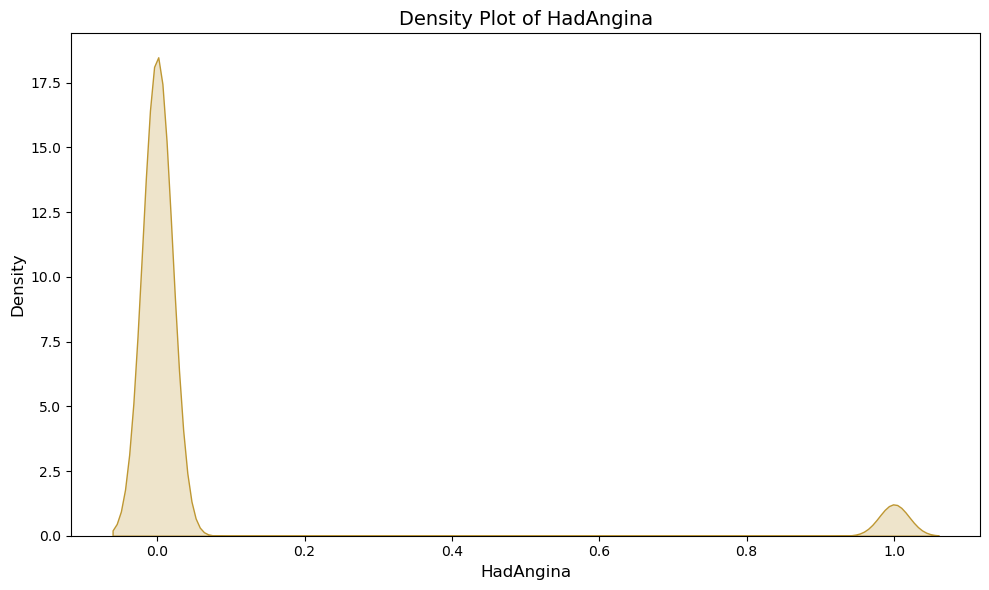

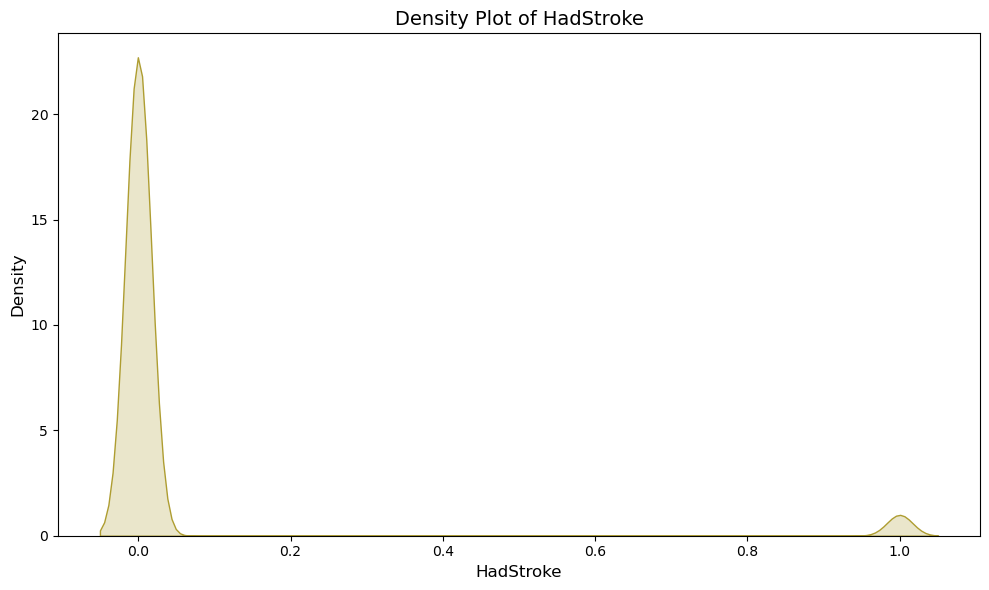

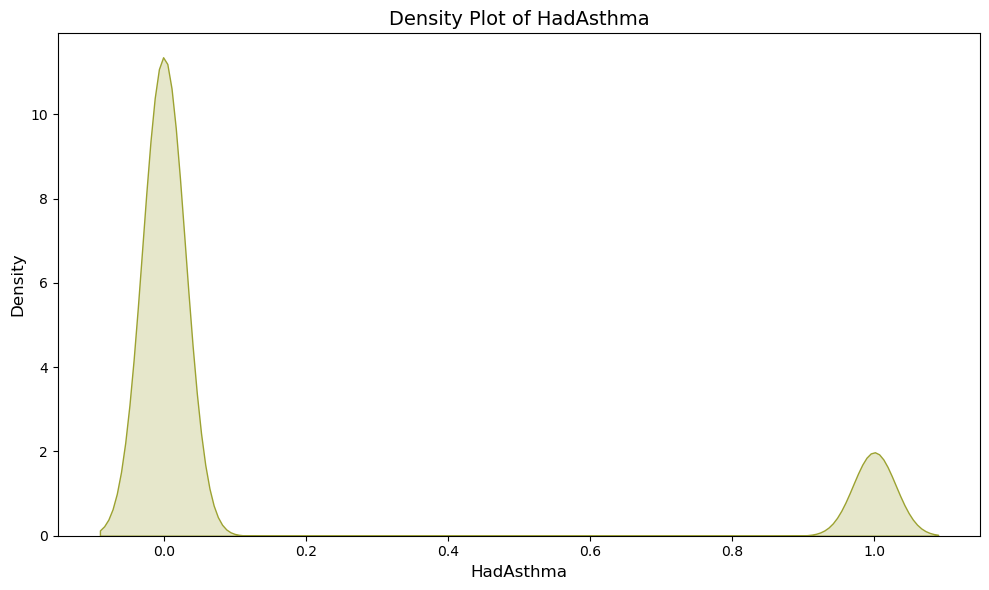

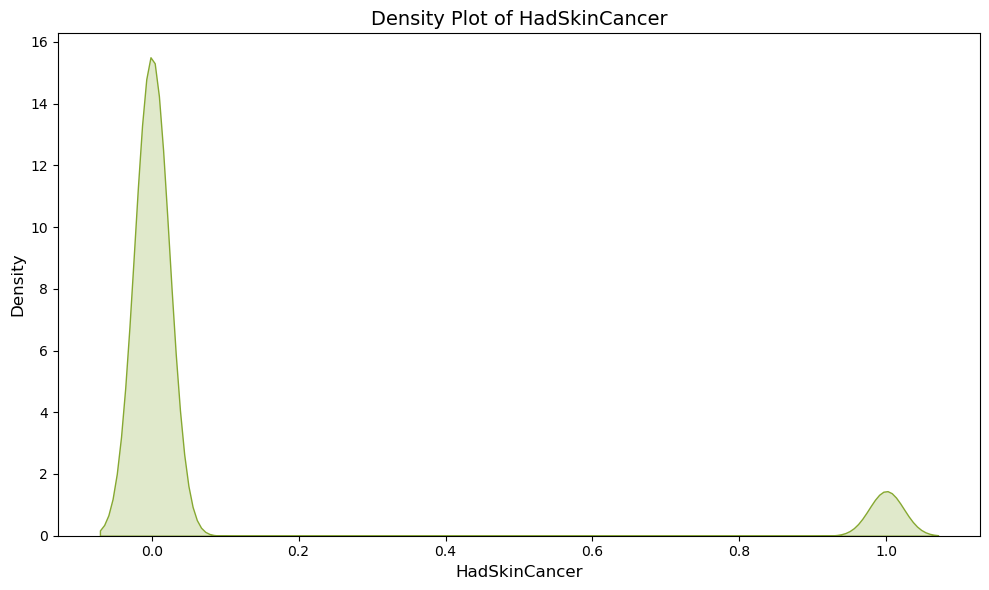

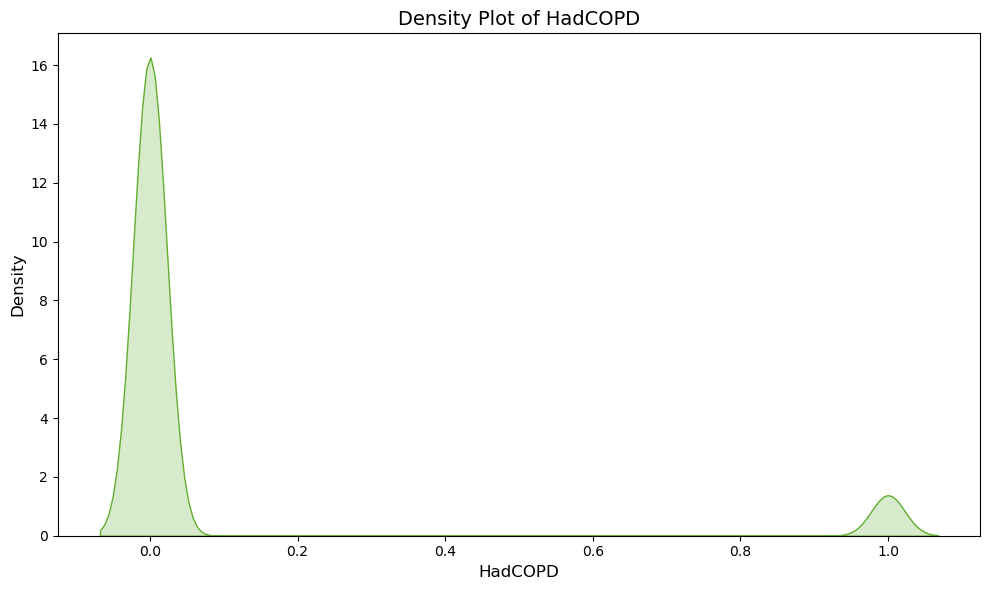

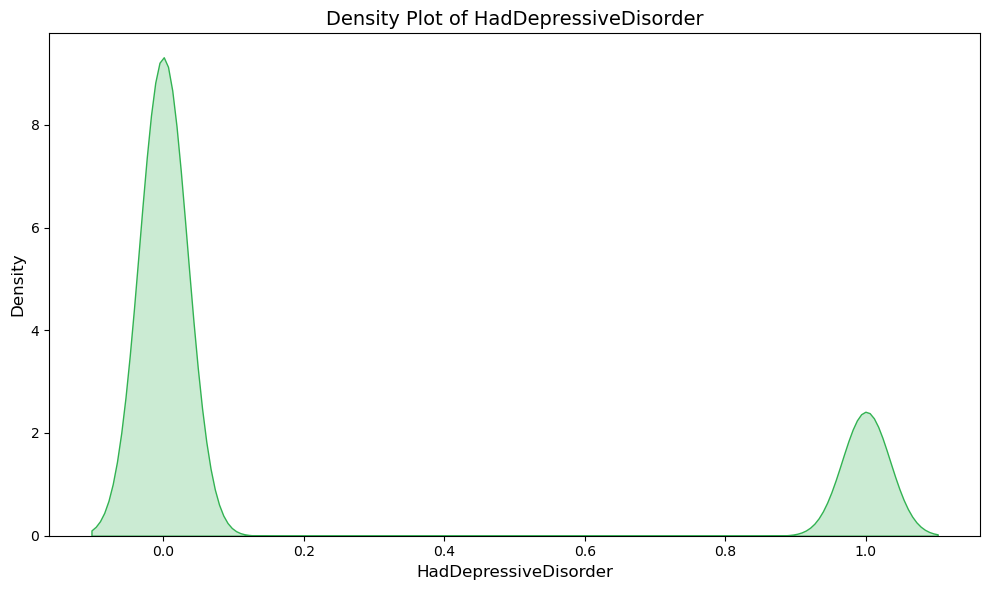

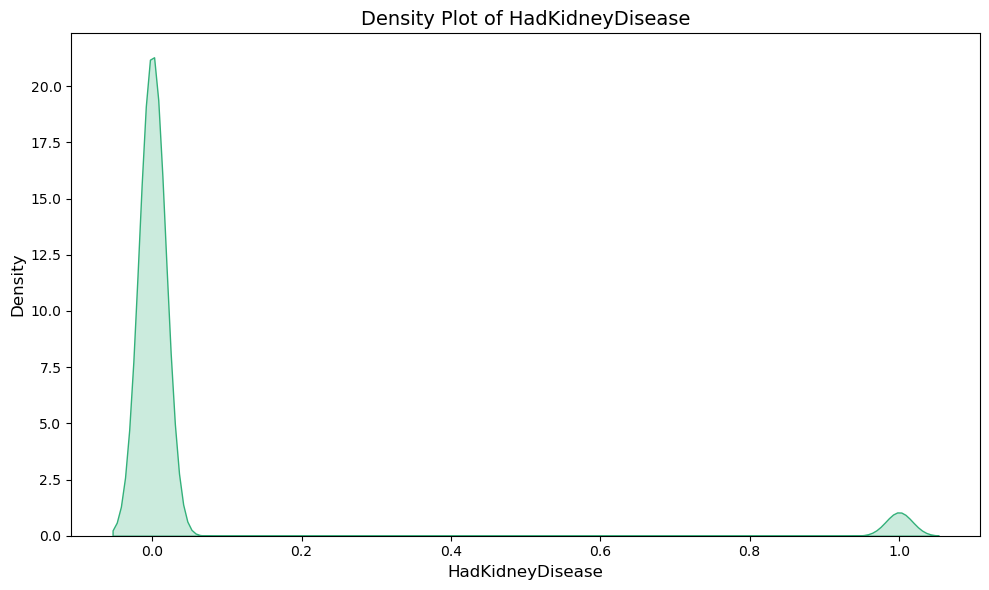

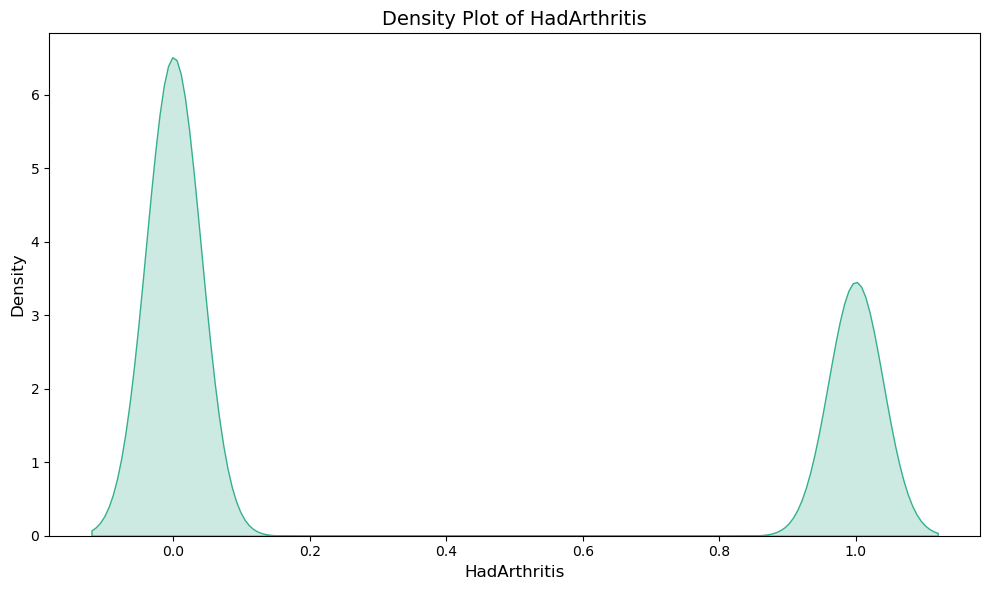

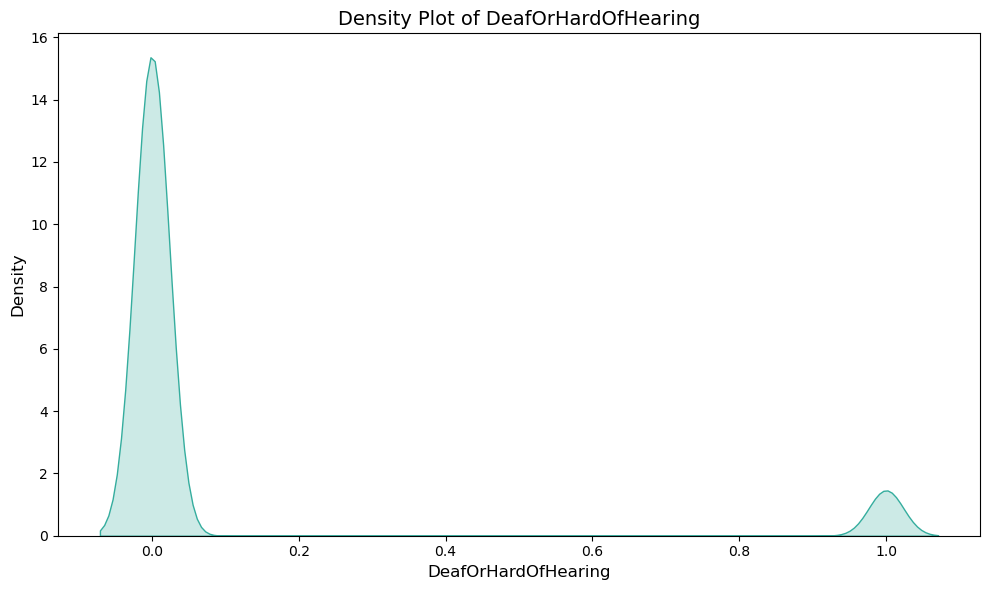

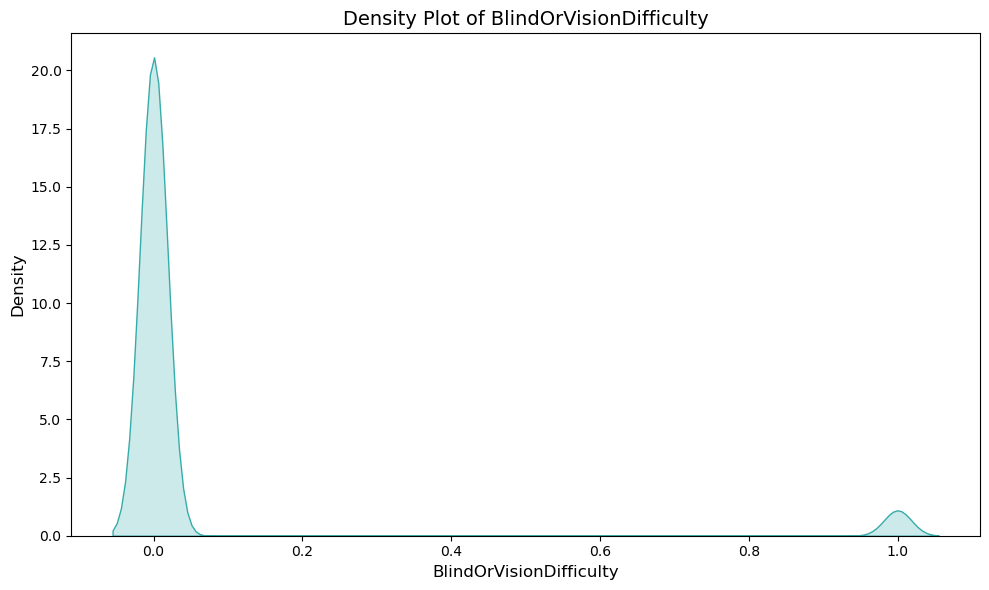

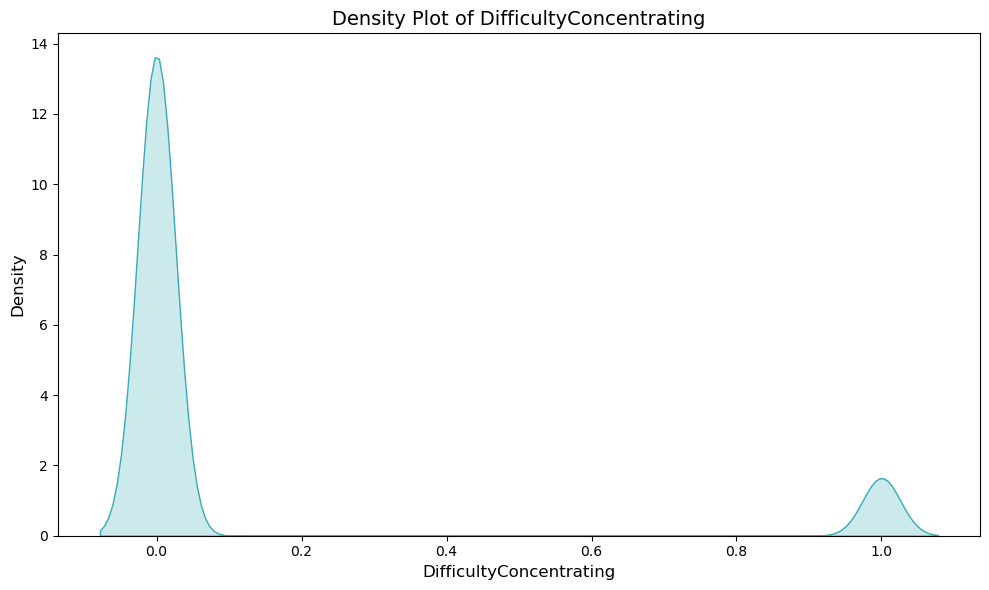

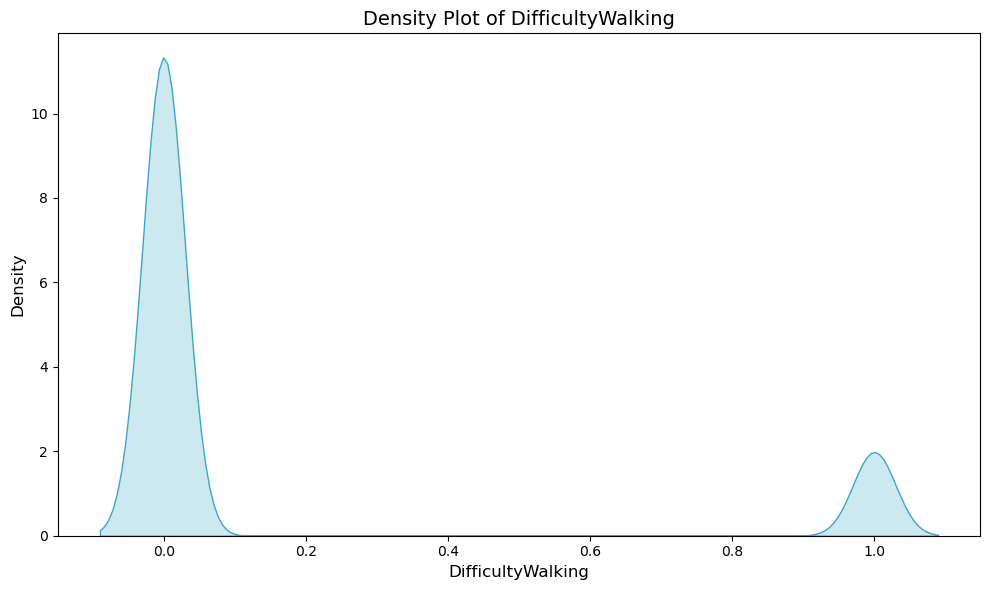

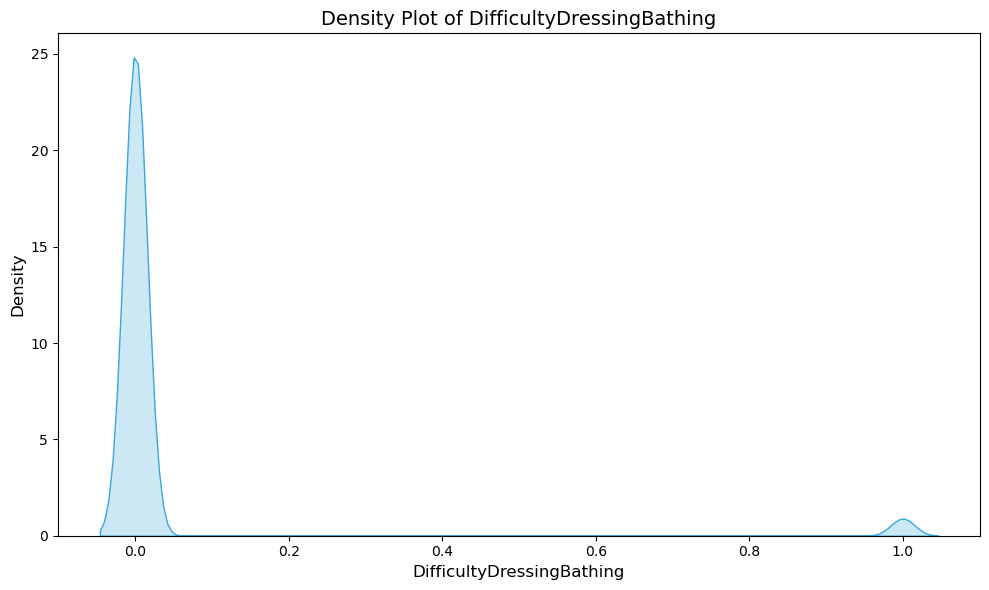

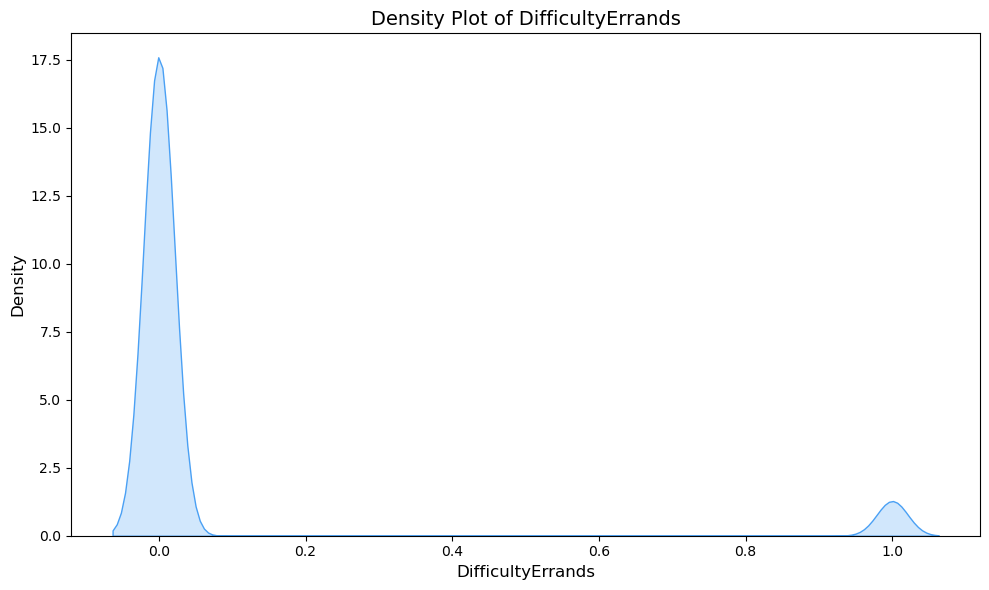

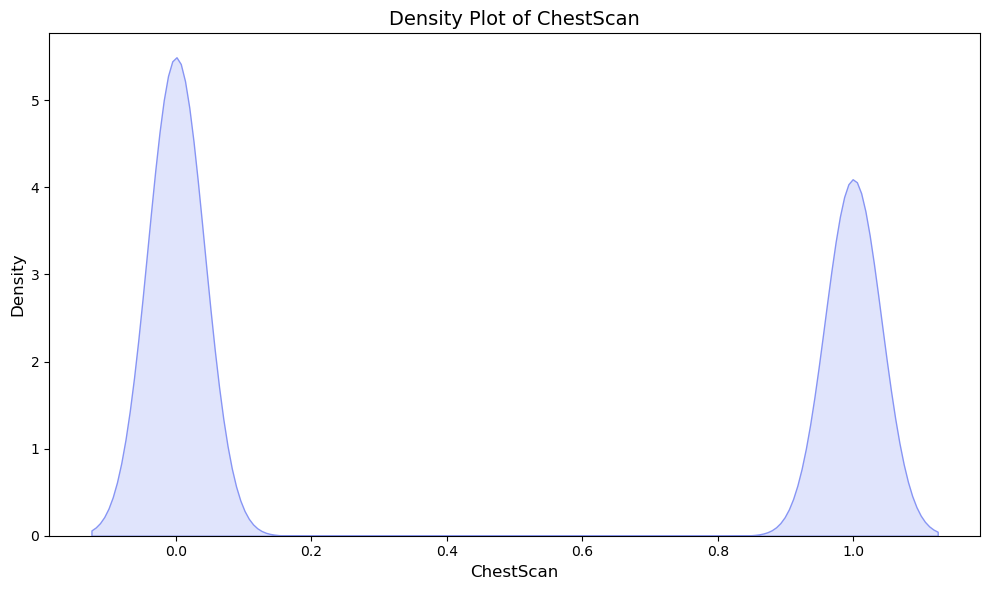

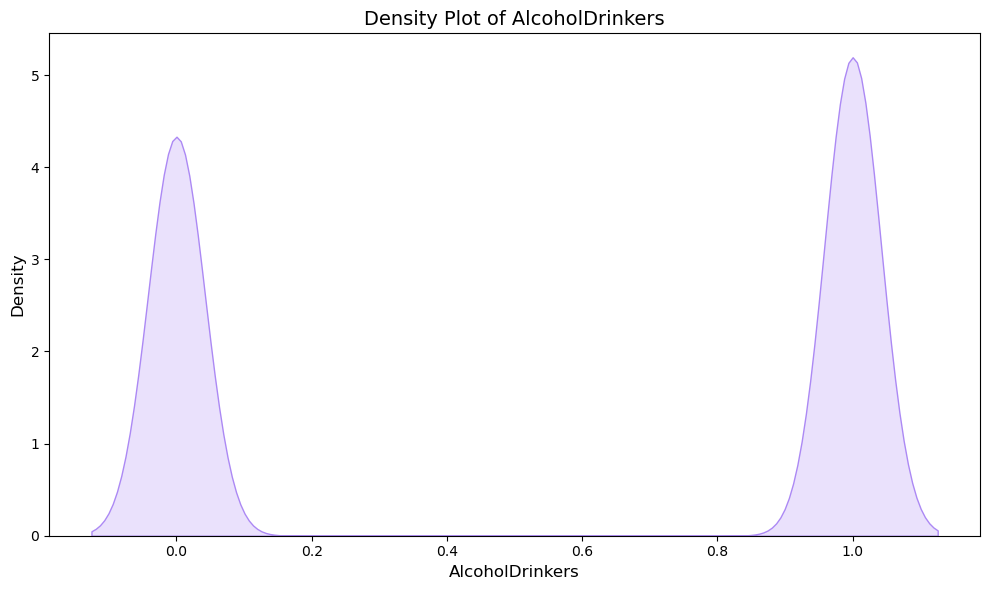

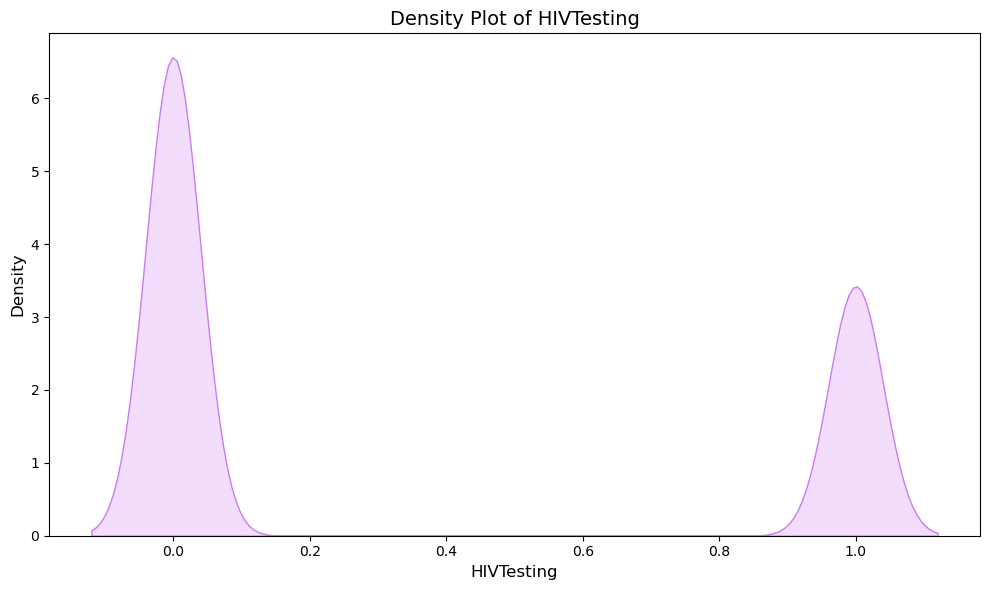

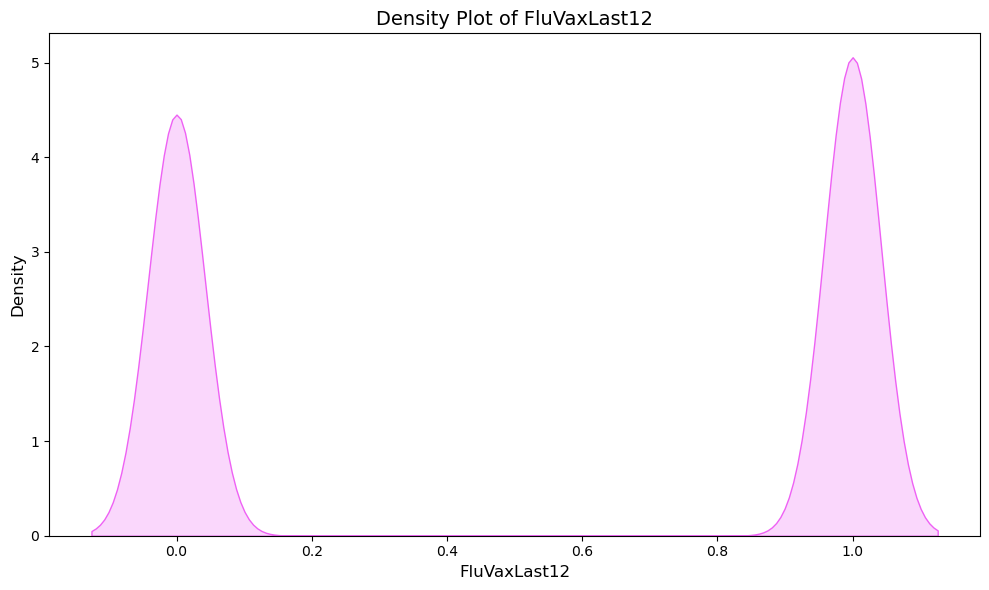

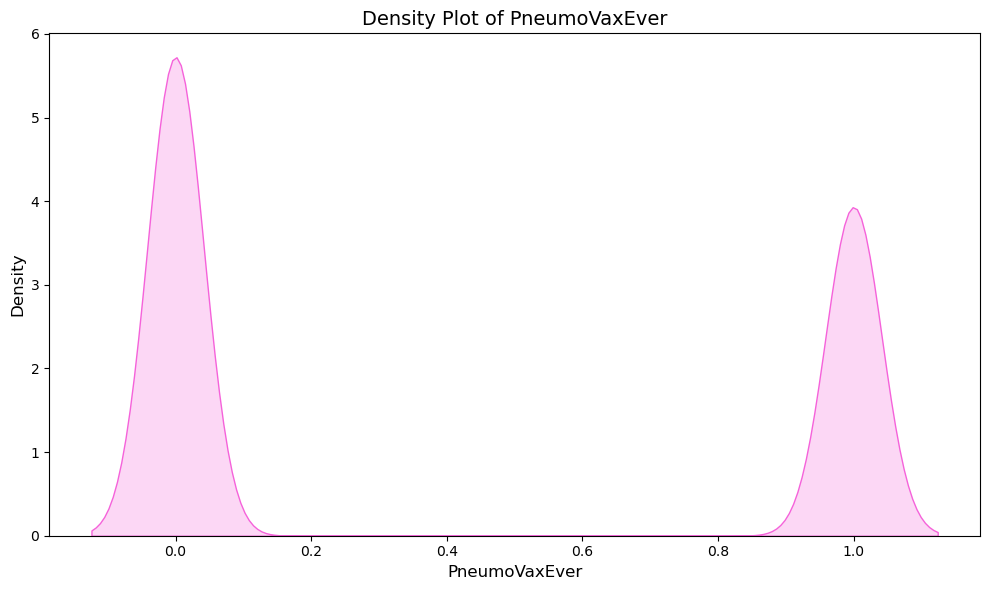

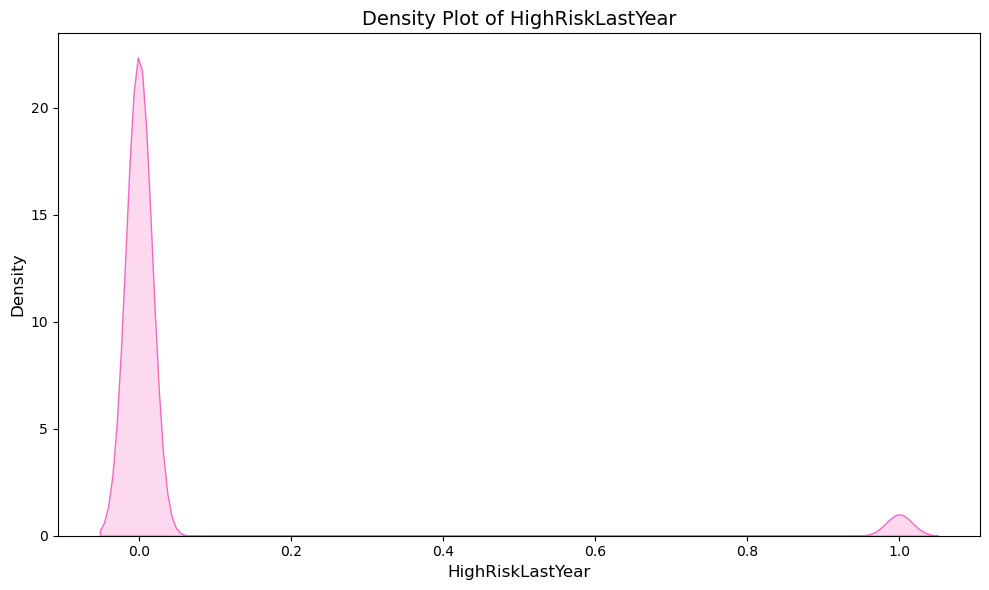

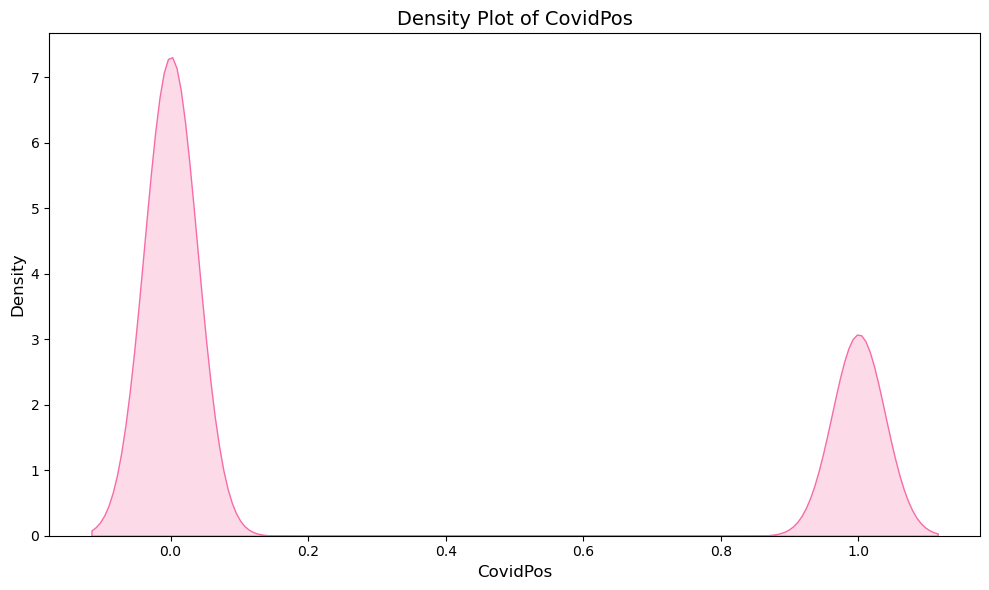

In [15]:
# Sürekli değişkenlerin seçilmesi
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Grafiklerin kaydedileceği plots klasörü
output_dir = "plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Farklı renkler için bir renk paleti tanımlıyoruz.
colors = sns.color_palette("husl", len(numerical_columns))

# Sürekli değişkenlerin dağılım grafikleri (histogram ve KDE)
for i, col in enumerate(numerical_columns):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col], kde=True, bins=20, color=colors[i])
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    
    # Grafik dosyasını kaydetme
    plt.savefig(os.path.join(output_dir, f"histogram_{col}.png"))
    plt.show()

# Sürekli değişkenlerin kutu grafikleri (boxplot)
for i, col in enumerate(numerical_columns):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[col], color=colors[i])
    plt.title(f"Boxplot of {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.tight_layout()
    
    # Grafik dosyasını kaydetme
    plt.savefig(os.path.join(output_dir, f"boxplot_{col}.png"))
    plt.show()

# Sürekli değişkenlerin yoğunluk grafikleri (density plot)
for i, col in enumerate(numerical_columns):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data[col], fill=True, color=colors[i])
    plt.title(f"Density Plot of {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.tight_layout()
    
    # Grafik dosyasını kaydetme
    plt.savefig(os.path.join(output_dir, f"density_{col}.png"))
    plt.show()


# 3. İstatistiksel Analiz ve Korelasyon

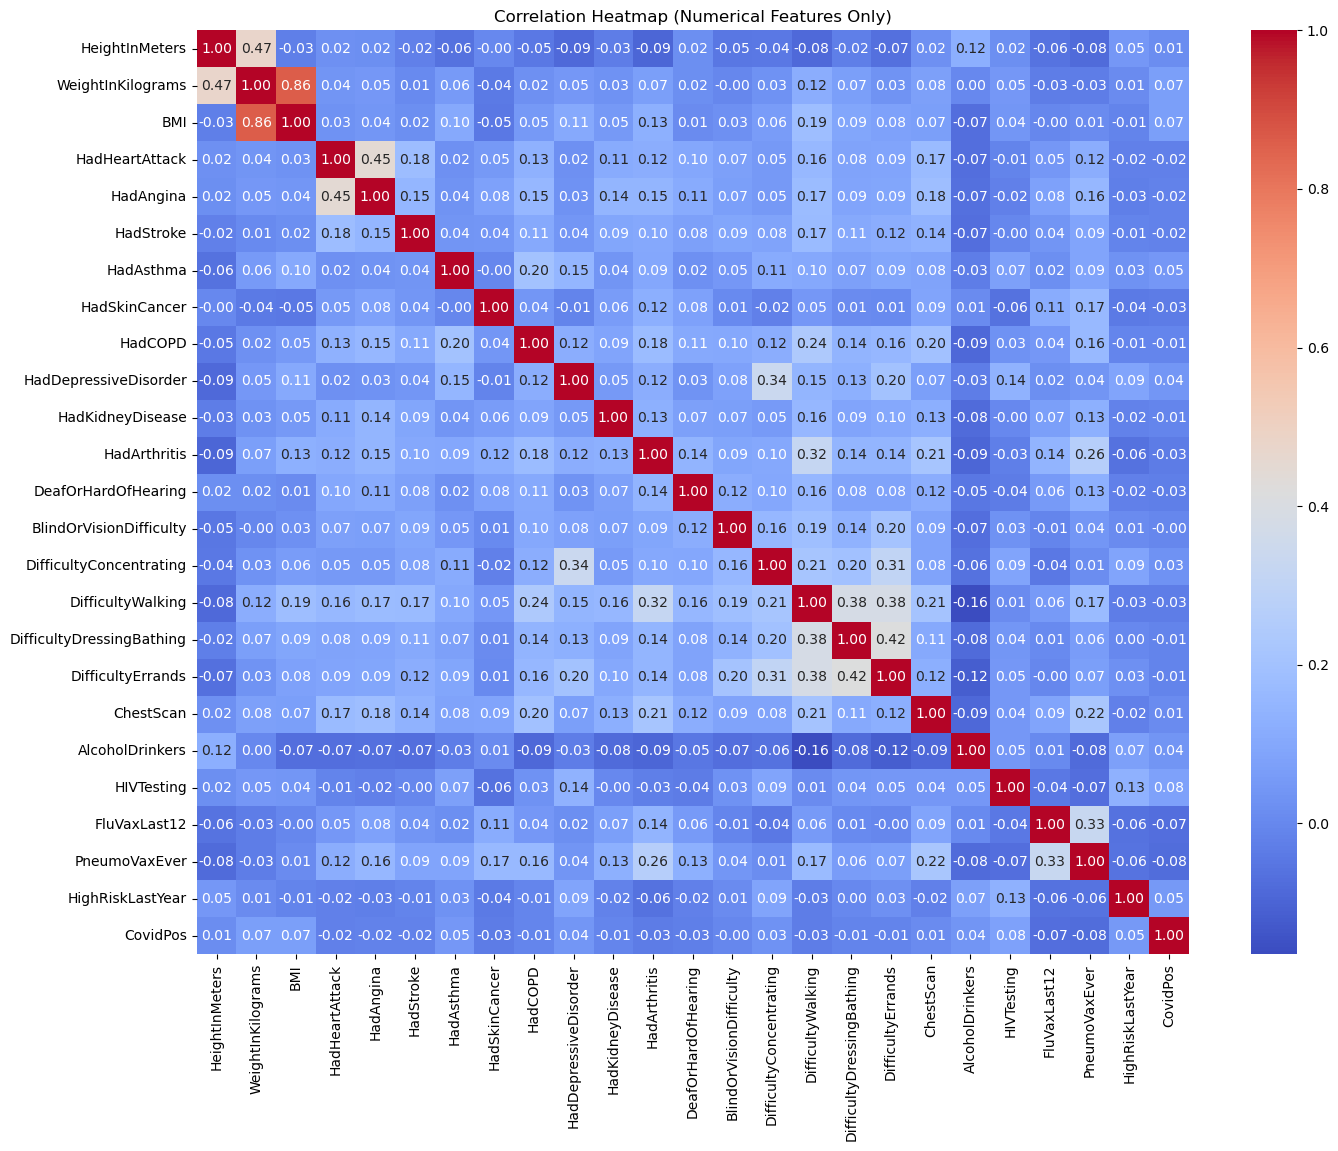

In [72]:
# Sadece sayısal sütunları seçme
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Grafiklerin kaydedileceği klasör
output_dir = "correlation matrix"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)   
    
# Korelasyon matrisi hesaplama ve görselleştirme
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features Only)")

# Grafiği kaydetme
file_path = os.path.join(output_dir, "correlation_heatmap.png")
plt.savefig(file_path)

plt.show()

# 4. Hipotez Testi

BMI (Body Mass Index) ile kalp krizi arasındaki ilişkiyi analiz etmek için hipotez testleri uygulandı.

In [18]:
# BMI ve Heart Attack
had_heart_attack = data[data['HadHeartAttack'] == 1]['BMI']
no_heart_attack = data[data['HadHeartAttack'] == 0]['BMI']

In [73]:
# T Test
t_stat, p_value = ttest_ind(had_heart_attack, no_heart_attack, nan_policy='omit')
print(f"T-Test: t_stat={t_stat}, p_value={p_value}")


T-Test: t_stat=14.720410470451446, p_value=5.011196515819722e-49


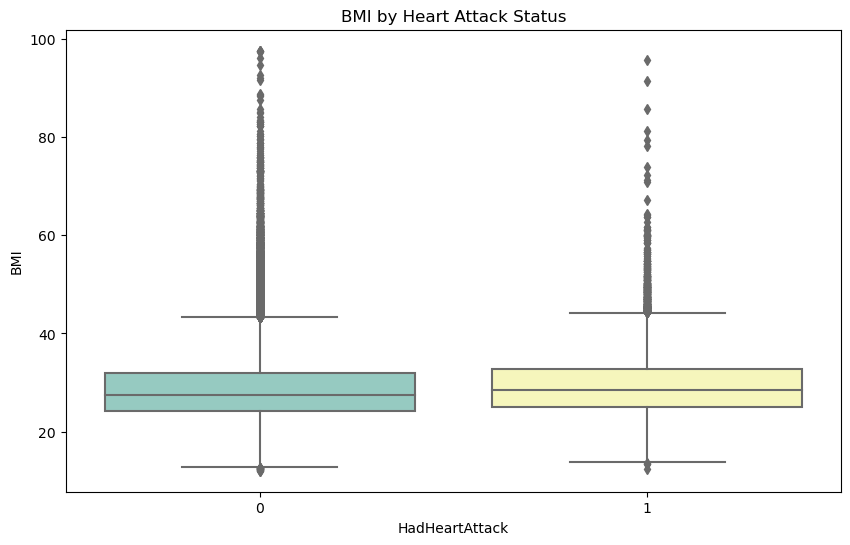

In [74]:
# 5. Görselleştirme: BMI ve Heart Attack Kutu Grafiği
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='HadHeartAttack', y='BMI', palette="Set3")
plt.title("BMI by Heart Attack Status")
plt.show()

In [75]:
# Çalışma sonuçları ve öneriler
print("Sonuçlar:")
print("- Analiz edilen değişkenlerden BMI, hedef değişken üzerinde yüksek bir etkiye sahip.")
print("- Veri setinde eksik değerler başarıyla doldurulmuştur.")
print("- Değişkenler arasındaki ilişkiler incelenmiş ve önemli desenler bulunmuştur.")
print("Öneriler:")
print("- Bu veri seti, sağlık durumu tahmini için regresyon modellerinde kullanılabilir.")
print("- Özellik mühendisliği adımlarıyla model performansı artırılabilir.")

Sonuçlar:
- Analiz edilen değişkenlerden BMI, hedef değişken üzerinde yüksek bir etkiye sahip.
- Veri setinde eksik değerler başarıyla doldurulmuştur.
- Değişkenler arasındaki ilişkiler incelenmiş ve önemli desenler bulunmuştur.
Öneriler:
- Bu veri seti, sağlık durumu tahmini için regresyon modellerinde kullanılabilir.
- Özellik mühendisliği adımlarıyla model performansı artırılabilir.


# Regresyon 

Regresyon için kullanılan kütüphaneler

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso


In [77]:
print(data.columns)

Index(['State', 'Sex', 'GeneralHealth', 'AgeCategory', 'HeightInMeters',
       'WeightInKilograms', 'BMI', 'HadHeartAttack', 'HadAngina', 'HadStroke',
       'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
       'HadKidneyDisease', 'HadArthritis', 'HadDiabetes',
       'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')


# 1. Regresyon Modeli İçin Hazırlık

In [78]:

# Hedef değişken ve özellikler
target_column = 'HadHeartAttack'  
X = data.drop(columns=[target_column])
y = data[target_column]

# Sayısal değişkenlerin normalleştirilmesi
X = pd.get_dummies(X, drop_first=True)  #one-hot encoding

# Eğitim ve test setleri
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Lineer Regresyon Modeli

In [79]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [80]:
# Tahmin ve değerlendirme
y_pred = linear_model.predict(X_test)
print("Linear Regression Results:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

Linear Regression Results:
Mean Squared Error: 0.04183561954922669
R-squared: 0.2274751711263968


# Ridge ve Lasso Regresyon Modelleri

In [81]:
# Ridge Regresyon
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
print("\nRidge Regression Results:")
print("Mean Squared Error:", mean_squared_error(y_test, ridge_pred))
print("R-squared:", r2_score(y_test, ridge_pred))




Ridge Regression Results:
Mean Squared Error: 0.04183553585031536
R-squared: 0.22747671668704228


In [82]:
# Lasso Regresyon
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)
print("\nLasso Regression Results:")
print("Mean Squared Error:", mean_squared_error(y_test, lasso_pred))
print("R-squared:", r2_score(y_test, lasso_pred))



Lasso Regression Results:
Mean Squared Error: 0.045316177589497846
R-squared: 0.1632041615556823


# Model Performans Karşılaştırması

In [83]:
# Performans metriklerini tablo olarak göstermek
results = {
    "Model": ["Linear Regression", "Ridge Regression", "Lasso Regression"],
    "Mean Squared Error": [
        mean_squared_error(y_test, y_pred),
        mean_squared_error(y_test, ridge_pred),
        mean_squared_error(y_test, lasso_pred)
    ],
    "R-squared": [
        r2_score(y_test, y_pred),
        r2_score(y_test, ridge_pred),
        r2_score(y_test, lasso_pred)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)


               Model  Mean Squared Error  R-squared
0  Linear Regression            0.041836   0.227475
1   Ridge Regression            0.041836   0.227477
2   Lasso Regression            0.045316   0.163204


Ridge Regression, hem en düşük MSE'yi sağlıyor hem de en yüksek R^2 değerine sahip.